# IMPORT

In [114]:
!pip install seaborn==0.10.1
!pip install -U scikit-learn
!pip install --upgrade pandas 
!pip install --upgrade s3fs
!pip install  googletrans

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: scikit-learn in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (0.23.1)
Requirement not upgraded as not directly required: joblib>=0.11 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (0.15.1)
Requirement not upgraded as not directly required: numpy>=1.13.3 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.14.6)
Requirement not upgraded as not directly required: threadpoolctl>=2.0.0 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (2.1.0)
Requirement not upgraded as not directly required: scipy>=0.19.1 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.1.0)
You are using pip ve

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [146]:
# import libraries here; add more as necessary
import os
import io

from time import gmtime, strftime

import  csv
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gc
import psutil
import re
from joblib import dump, load

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.preprocessing import Normalizer, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from scipy import sparse

from googletrans import Translator

import sagemaker
import boto3
import s3fs
from sagemaker import PCA,KMeans
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.amazon.common import write_spmatrix_to_sparse_tensor, write_numpy_to_dense_tensor
from sagemaker.s3 import S3Uploader
import mxnet as mx



# magic word for producing visualizations in notebook
%matplotlib inline

# CUSTOM FUNCTIONS

In [147]:
from utils.custom_transformers import cleaning, naning, low_freq
from utils.helper import *
from utils.clean import clean_fn

# Global variables

In [148]:
session = sagemaker.session.Session()
role = sagemaker.get_execution_role()
bucket = 'auto-ml-exploration'

In [149]:
INIT_DATA_FOLDER = 'initial_data' 
INITIAL_DATA_SAVEPTH_S3 = f's3://{bucket}/{INIT_DATA_FOLDER}'
s3_dataset_path = f's3://{bucket}/dataset'

CLEANED_DATA_FOLDER = 'cleaned_data' 
CLEANED_DATA_SAVEPTH_S3 = f's3://{bucket}/{CLEANED_DATA_FOLDER}'

TRANSFORMED_DATA_FOLDER = 'transformed_data'
TRANSFORMED_DATA_SAVEPTH_S3 = f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}'

In [150]:
s3fs_handler = s3fs.S3FileSystem()

In [151]:
translator = Translator()

# DATA STORAGE TO S3

In [17]:
sagemaker.s3.S3Uploader.upload('Udacity_AZDIAS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_CUSTOMERS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TEST.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TRAIN.csv', s3_dataset_path)

sagemaker.s3.S3Uploader.upload('DIAS Attributes - Values 2017.xlsx', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('DIAS Information Levels - Attributes 2017.xlsx', s3_dataset_path)

's3://auto-ml-exploration/dataset/DIAS Information Levels - Attributes 2017.xlsx'

In [152]:
# data location on S3
pop_dataset_loc = f's3://{bucket}/dataset/Udacity_AZDIAS_052018.csv'
customers_dataset_loc = f's3://{bucket}/dataset/Udacity_CUSTOMERS_052018.csv'
mailout_train_dataset_loc = f's3://{bucket}/dataset/Udacity_MAILOUT_052018_TRAIN.csv'
mailout_test_dataset_loc = f's3://{bucket}/dataset/Udacity_MAILOUT_052018_TEST.csv'

# Choose dataset to work on

In [153]:
flag = ('pop', 'customers', 'mailout') # 'pop' or 'customers'

# used to perform correct operations depending on dataset to be analyzed

## Load & save to pickle if necessary

In [154]:
if isinstance(flag, tuple):
    dataset  = {}
    for item in flag:
        if s3fs_handler.exists(f'{INITIAL_DATA_SAVEPTH_S3}/{item}_complete_df.pkl'):
            print(f"read {item} from pickled file")
            dataset[item] = pd.read_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/{item}_complete_df.pkl')
        else:
            if item=="pop":
                dataset[item] = pd.read_csv(pop_dataset_loc, sep=';')
            elif item=="customers":
                dataset[item] = pd.read_csv(customers_dataset_loc, sep=';')
                # drop immediately columns that will never be used
                dataset[item] = dataset[item].drop(['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP'], axis=1)
            elif "mailout" in item:
                dataset[item] = pd.read_csv(mailout_train_dataset_loc, sep=';')

            dataset[item].to_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/{item}_complete_df.pkl')
else:
    if s3fs_handler.exists(f'{INITIAL_DATA_SAVEPTH_S3}/{flag}_complete_df.pkl'):
            print("read from pickled file")
            dataset = pd.read_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/{flag}_complete_df.pkl')
    else:
        if flag=="pop":
            dataset = pd.read_csv(pop_dataset_loc, sep=';')
        elif flag=="customers":
            dataset = pd.read_csv(customers_dataset_loc, sep=';')
            # drop immediately columns that will never be used
            dataset = dataset.drop(['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP'], axis=1)
        elif "mailout" in flag:
            dataset = pd.read_csv(mailout_train_dataset_loc, sep=';')

        dataset.to_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/{flag}_complete_df.pkl')

read pop from pickled file
read customers from pickled file
read mailout from pickled file


# Explore Data

## Create directory to save graphs

In [29]:
Path('img/exploration').mkdir(exist_ok=True, parents=True)

## Handle graphs font size

In [63]:
# SMALL_SIZE = 10
# MEDIUM_SIZE = 16
# BIGGER_SIZE = 20

# matplotlib.rcParams['font.size'] =MEDIUM_SIZE
# matplotlib.rcParams['axes.titlesize'] =MEDIUM_SIZE
# matplotlib.rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
# matplotlib.rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
# matplotlib.rcParams['ytick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
# matplotlib.rcParams['legend.fontsize'] =MEDIUM_SIZE    # legend fontsize
# matplotlib.rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title

# # to get all possible params : matplotlib.rcParams.keys()


## General statistics

In [30]:
dataset.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [206]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363212 entries, 0 to 363211
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(289), int64(71), object(6)
memory usage: 1014.2+ MB


In [5]:
dataset.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,3.632120e+05,363212.000000,333574.000000,333574.000000,33147.000000,12166.000000,2547.000000,501.000000,256099.000000,325550.000000,...,313999.000000,332579.000000,332579.000000,332579.000000,319597.000000,333573.000000,325549.000000,363211.000000,363211.000000,363211.000000
mean,6.366678e+05,-0.359198,4.427036,10.858295,11.739132,13.444764,14.555556,15.051896,13.705383,8.267182,...,2.420610,6.004528,7.537704,5.952147,3.929643,7.910367,4.048011,3.359160,1.522184,2.776491
std,2.558490e+05,1.198028,3.639139,7.644164,4.085674,3.248806,2.643738,2.444034,5.078172,15.597372,...,1.165968,2.857556,3.249021,2.773321,1.964833,1.922841,1.950010,1.355002,0.499508,1.068990
min,1.916550e+05,-1.000000,1.000000,0.000000,2.000000,3.000000,5.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.159545e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.334155e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.575152e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


# Construct features information from Excel file

In [155]:
levels_description = pd.read_excel('DIAS Attributes - Values 2017_custom.xlsx', # Added Data Type
                                   header=1, usecols=[1,2,3,4,5,6]).fillna(method = 'ffill')
features_description = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', 
                                     header=1, usecols=[1,2,3,4,5,6]).fillna(method = 'ffill').fillna(method = 'bfill')

global_info = (pd.merge(levels_description, features_description, how='inner', on='Attribute')
               .drop(['Additional notes','Description_y'],axis=1))

# Analyze missing values per features (np.nan)

In [156]:
dataset = pd.concat([dataset['pop'].assign(dataset='population'), 
                     dataset['customers'].assign(dataset='customers'),
                     dataset['mailout'].assign(dataset='mailout')])

## Make better index

In [4]:
dataset.set_index('LNR', inplace=True)

In [36]:
dataset.loc[dataset['dataset']=='customers',:].head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,dataset,RESPONSE
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0,customers,NaN
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,3.0,0.0,9.0,NaN,3.0,1.0,4.0,customers,NaN
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0,customers,NaN
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,4.0,2.0,NaN,9.0,7.0,1.0,1.0,4.0,customers,NaN
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,5.0,4.0,2.0,9.0,3.0,1.0,1.0,3.0,customers,NaN


In [37]:
dataset.loc[dataset['dataset']=='mailout',:].head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,dataset,RESPONSE
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,2.0,1.0,6.0,9.0,3.0,3.0,2.0,4.0,mailout,0.0
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,2.0,1.0,4.0,9.0,7.0,1.0,2.0,3.0,mailout,0.0
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,4.0,2.0,NaN,9.0,2.0,3.0,1.0,4.0,mailout,0.0
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,11.0,11.0,6.0,9.0,1.0,3.0,2.0,4.0,mailout,0.0
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,1.0,6.0,9.0,3.0,3.0,1.0,3.0,mailout,0.0


In [12]:
nan_counts = dataset.drop('dataset', axis=1).isna().groupby(dataset.dataset, sort=False).sum().sort_values(by='population', axis=1, ascending=False)

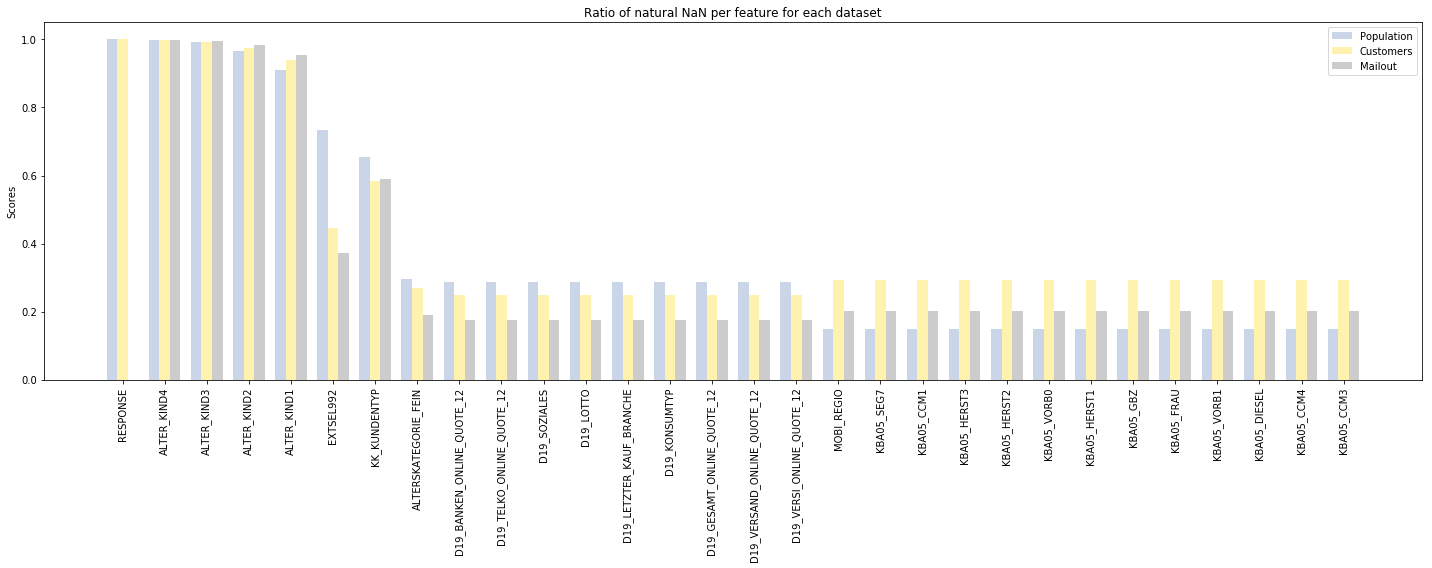

In [13]:
top_ = 30
from matplotlib import cm

step = 2
fig, ax = plt.subplots(figsize=(20,8))

x = np.arange(step*len(nan_counts.columns[:top_]), step=step)  # the label locations
width = 0.5  # the width of the bars
cmap = cm.get_cmap('Pastel2')

rects1 = ax.bar(x - 1*width, nan_counts.iloc[0,:top_]/dataset.loc[dataset['dataset']=='population', :].shape[0], width, label='Population', color = cmap(0.33))
rects2 = ax.bar(x, nan_counts.iloc[1,:top_]/dataset.loc[dataset['dataset']=='customers', :].shape[0], width, label='Customers', color = cmap(0.66))
rects3 = ax.bar(x+1*width, nan_counts.iloc[2,:top_]/dataset.loc[dataset['dataset']=='mailout', :].shape[0], width, label='Mailout', color = cmap(1.0))

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel('Scores')
ax.set_title('Ratio of natural NaN per feature for each dataset')
ax.set_xticks(x)
ax.set_xticklabels(nan_counts.columns)
ax.legend()

fig.tight_layout()


fig.savefig(Path('img/exploration').joinpath(f'{flag}_nanNaturalPerFeature_PERCENT'))

In [13]:
nan_info, replacements = construct_fill_na_new(global_info, dataset)

In [14]:
dataset = fill_na_presc(dataset, nan_info)

In [15]:
nan_counts = dataset.drop('dataset', axis=1).isna().groupby(dataset.dataset, sort=False).sum().sort_values(by='population', axis=1, ascending=False)

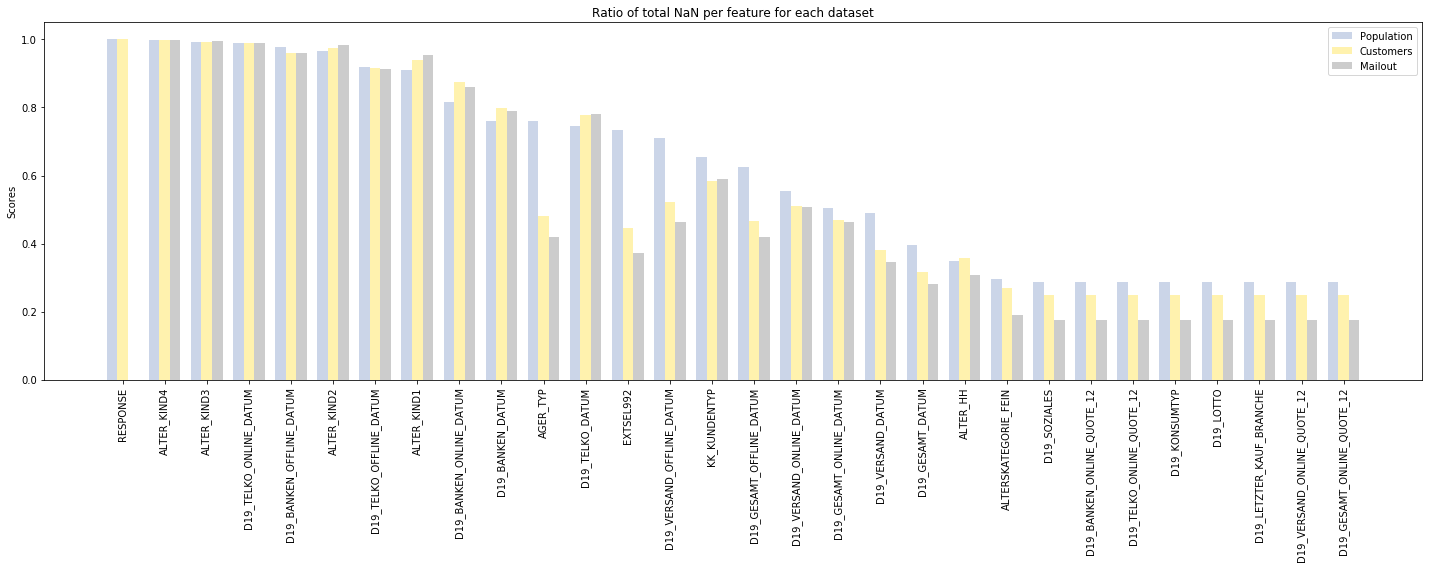

In [25]:
top_ = 30
from matplotlib import cm

step = 2
fig, ax = plt.subplots(figsize=(20,8))

x = np.arange(step*len(nan_counts.columns[:top_]), step=step)  # the label locations
width = 0.5  # the width of the bars
cmap = cm.get_cmap('Pastel2')

pop_samples = dataset.loc[dataset['dataset']=='population', :].shape[0]
customers_samples = dataset.loc[dataset['dataset']=='customers', :].shape[0]
mailout_samples = dataset.loc[dataset['dataset']=='mailout', :].shape[0]

rects1 = ax.bar(x - 1*width, nan_counts.iloc[0,:top_]/pop_samples, width, label='Population', color = cmap(0.33))
rects2 = ax.bar(x, nan_counts.iloc[1,:top_]/customers_samples, width, label='Customers', color = cmap(0.66))
rects3 = ax.bar(x+1*width, nan_counts.iloc[2,:top_]/mailout_samples, width, label='Mailout', color = cmap(1.0))

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel('Scores')
ax.set_title('Ratio of total NaN per feature for each dataset')
ax.set_xticks(x)
ax.set_xticklabels(nan_counts.columns)
ax.legend()

fig.tight_layout()


fig.savefig(Path('img/exploration').joinpath(f'{flag}_nanTotalPerFeature_PERCENT'))

In [48]:
# identify columns that would be removed based on a certain threshold and depending on the considered dataset
thresh = 0.70
pop_total_remove = set(nan_counts.loc["population", nan_counts.loc["population",:]/pop_samples > thresh].index)
customers_total_remove = set(nan_counts.loc["customers", nan_counts.loc["customers",:]/customers_samples > thresh].index)
mailout_total_remove = set(nan_counts.loc["mailout", nan_counts.loc["mailout",:]/mailout_samples > thresh].index)


print('Based on population data, the following columns would be removed based on total NaN'
      'and a threshold of {:2.0%}:\n{}'.format(
      thresh, '\n'.join(pop_total_remove))
     )

print('\n')

print('Based on customers data, the following columns would be removed based on total NaN' 
      'and a threshold of {:2.0%}:\n{}'.format(
      thresh, '\n'.join(customers_total_remove))
     )

print('\n')

print('Based on mailout training data, the following columns would be removed based on total NaN'
      'and a threshold of {:2.0%}:\n{}'.format(
      thresh, '\n'.join(mailout_total_remove))
     )

print('\n')

print(('common features to be removed between all three datasets with a threshold of {} :\n{}'
        .format(thresh, '\n'.join(pop_total_remove.intersection(customers_total_remove).intersection(mailout_total_remove)))))

print('\n')

print(('features to be removed based on population dataset but not customers dataset' 
       'with a threshold of {} :\n{}'
        .format(thresh, '\n'.join(pop_total_remove.difference(customers_total_remove)))))

print('\n')

print(('features to be removed based on population dataset but not mailout dataset' 
       'with a threshold of {} :\n{}'
        .format(thresh, '\n'.join(pop_total_remove.difference(mailout_total_remove)))))

print('\n')

print(('features to be removed based on customers dataset but not mailout dataset' 
       'with a threshold of {} :\n{}'
        .format(thresh, '\n'.join(customers_total_remove.difference(mailout_total_remove)))))



Based on population data, the following columns would be removed based on total NaNand a threshold of 70%:
AGER_TYP
D19_TELKO_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
ALTER_KIND1
EXTSEL992
D19_VERSAND_OFFLINE_DATUM
D19_TELKO_OFFLINE_DATUM
D19_BANKEN_DATUM
ALTER_KIND3
ALTER_KIND2
ALTER_KIND4
RESPONSE


Based on customers data, the following columns would be removed based on total NaNand a threshold of 70%:
D19_TELKO_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
ALTER_KIND1
D19_TELKO_OFFLINE_DATUM
D19_BANKEN_DATUM
ALTER_KIND3
ALTER_KIND2
ALTER_KIND4
RESPONSE


Based on mailout training data, the following columns would be removed based on total NaNand a threshold of 70%:
D19_TELKO_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
ALTER_KIND1
D19_TELKO_OFFLINE_DATUM
D19_BANKEN_DATUM
ALTER_KIND3
ALTER_KIND2
ALTER_KIND4


common features to be removed between all three datasets with a threshold 

## Check to_drop candidates on mailout dataset

In [16]:
to_drop_candidates = ["ALTER_KIND2", "ALTER_KIND3", "ALTER_KIND4", "ALTER_KIND1",
"D19_DIGIT_SERV" , "D19_BANKEN_LOKAL", "D19_VERSI_OFFLINE_DATUM", "D19_BANKEN_REST", "D19_VERSI_ONLINE_DATUM", "D19_GARTEN" ,
"D19_TELKO_ANZ_12", "D19_BANKEN_ANZ_24", "D19_ENERGIE", "D19_VERSI_ANZ_12", "D19_BANKEN_ANZ_12", "D19_BANKEN_GROSS", "D19_BIO_OEKO", 
"D19_NAHRUNGSERGAENZUNG" , "D19_TELKO_ANZ_24",
"D19_TELKO_ONLINE_QUOTE_12", "D19_SAMMELARTIKEL", "D19_KOSMETIK", "D19_DROGERIEARTIKEL", "D19_WEIN_FEINKOST", "D19_VERSAND_REST", 
"D19_TELKO_MOBILE", "D19_TELKO_REST", "D19_VERSI_ANZ_24", "D19_VERSICHERUNGEN", "D19_VERSICHERUNGEN", "D19_VERSI_DATUM", "D19_LEBENSMITTEL", 
"D19_SCHUHE" , "D19_VERSI_ONLINE_QUOTE_12", "D19_KINDERARTIKEL", "D19_HAUS_DEKO", "D19_BANKEN_DIREKT", "D19_BILDUNG", "D19_RATGEBER", 
"D19_HANDWERK", "D19_FREIZEIT", "ANZ_KINDER", "D19_LOTTO", "ALTERSKATEGORIE_FEIN", "EINGEZOGENAM_HH_JAHR", "EINGEFUEGT_AM"]

In [17]:
for feature in to_drop_candidates:
    describe_feature(dataset.loc[dataset.loc[:,'dataset']=='mailout', :],feature)
    print('\n')

feature ALTER_KIND2 is categorized as float64 per panda
It means AGE CHILD2 in english
it has 14 different values
value 17.0 has 99.0 samples and represents 0.23% of data
value 12.0 has 87.0 samples and represents 0.20% of data
value 18.0 has 87.0 samples and represents 0.20% of data
value 14.0 has 80.0 samples and represents 0.19% of data
value 15.0 has 79.0 samples and represents 0.18% of data
value 16.0 has 77.0 samples and represents 0.18% of data
value 13.0 has 72.0 samples and represents 0.17% of data
value 11.0 has 58.0 samples and represents 0.14% of data
value 10.0 has 42.0 samples and represents 0.10% of data
value 9.0 has 31.0 samples and represents 0.07% of data
value 8.0 has 22.0 samples and represents 0.05% of data
value 7.0 has 13.0 samples and represents 0.03% of data
value 6.0 has 5.0 samples and represents 0.01% of data
value 5.0 has 4.0 samples and represents 0.01% of data
it presents 98.24% natural NaN


feature ALTER_KIND3 is categorized as float64 per panda
It mea

feature D19_ENERGIE is categorized as int64 per panda
It means D19 ENERGY in english
it has 8 different values
value 0 has 39064.0 samples and represents 90.93% of data
value 6 has 1326.0 samples and represents 3.09% of data
value 3 has 1244.0 samples and represents 2.90% of data
value 5 has 597.0 samples and represents 1.39% of data
value 7 has 391.0 samples and represents 0.91% of data
value 2 has 183.0 samples and represents 0.43% of data
value 4 has 93.0 samples and represents 0.22% of data
value 1 has 64.0 samples and represents 0.15% of data
it has no natural NaN


feature D19_VERSI_ANZ_12 is categorized as int64 per panda
It means D19 VERSI NUMBER 12th in english
it has 7 different values
value 0 has 39485.0 samples and represents 91.91% of data
value 1 has 2327.0 samples and represents 5.42% of data
value 2 has 965.0 samples and represents 2.25% of data
value 3 has 141.0 samples and represents 0.33% of data
value 4 has 37.0 samples and represents 0.09% of data
value 5 has 6.0 s

feature D19_VERSI_ANZ_24 is categorized as int64 per panda
It means D19 VERSI NUMBER 24th in english
it has 7 different values
value 0 has 37473.0 samples and represents 87.22% of data
value 1 has 3287.0 samples and represents 7.65% of data
value 2 has 1668.0 samples and represents 3.88% of data
value 3 has 355.0 samples and represents 0.83% of data
value 4 has 156.0 samples and represents 0.36% of data
value 5 has 21.0 samples and represents 0.05% of data
value 6 has 2.0 samples and represents 0.00% of data
it has no natural NaN


feature D19_VERSICHERUNGEN is categorized as int64 per panda
It means D19 INSURANCE in english
it has 8 different values
value 0 has 32015.0 samples and represents 74.52% of data
value 6 has 5217.0 samples and represents 12.14% of data
value 3 has 2327.0 samples and represents 5.42% of data
value 5 has 1474.0 samples and represents 3.43% of data
value 2 has 714.0 samples and represents 1.66% of data
value 4 has 538.0 samples and represents 1.25% of data
valu

feature D19_LOTTO is categorized as float64 per panda
It means D19 LOTTO in english
it has 7 different values
value 0.0 has 20293.0 samples and represents 47.23% of data
value 7.0 has 12714.0 samples and represents 29.59% of data
value 6.0 has 2174.0 samples and represents 5.06% of data
value 3.0 has 108.0 samples and represents 0.25% of data
value 5.0 has 86.0 samples and represents 0.20% of data
value 4.0 has 2.0 samples and represents 0.00% of data
value 2.0 has 1.0 samples and represents 0.00% of data
it presents 17.65% natural NaN


feature ALTERSKATEGORIE_FEIN is categorized as float64 per panda
It means AGE CATEGORY FINE in english
it has 25 different values
value 9.0 has 5045.0 samples and represents 11.74% of data
value 10.0 has 4681.0 samples and represents 10.90% of data
value 0.0 has 3536.0 samples and represents 8.23% of data
value 8.0 has 3332.0 samples and represents 7.76% of data
value 12.0 has 3188.0 samples and represents 7.42% of data
value 11.0 has 3049.0 samples an

## Check per sample NaN distribution

In [132]:
n_features = len(dataset.columns)

In [137]:
test = dataset.loc[dataset.loc[:,'dataset']=='mailout', :].isna().sum(axis=1)/n_features*100

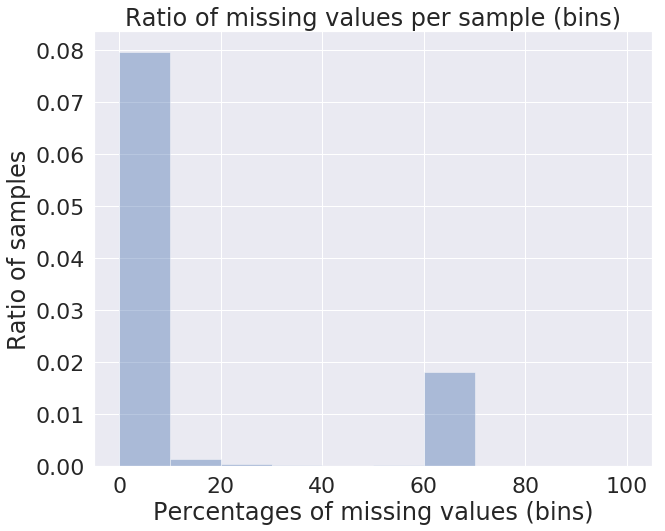

In [138]:
# the same in percent

sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(10,8))
g = sns.distplot(test.values, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], hist=True,
                 norm_hist = True, kde = False)

ax.set_ylabel('Ratio of samples')
ax.set_xlabel('Percentages of missing values (bins)')
ax.set_title('Ratio of missing values per sample (bins)')

fig.savefig(Path('img/exploration').joinpath('per_sample_nan_customers'))

# one sees a significant drop between 6th first columns and the rest
# a ratio of nan around 65% should do it

### What is interesting also is to check, for mailout dataset, which samples get deleted based on NaN criterion

Indeed, since the dataset is highly imbalanced (way more non-customres than customers), deleting non-customers sample can help temper this imbalance

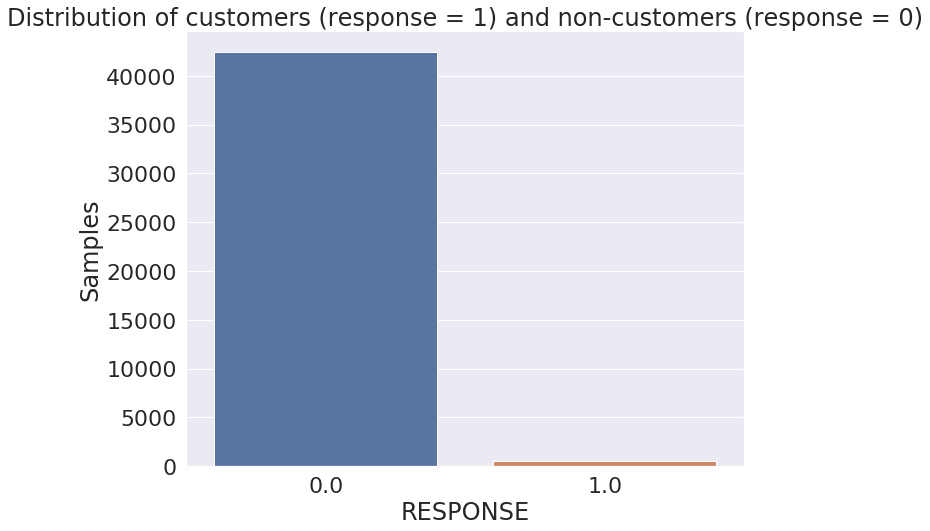

In [129]:
# the same in percent

sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(10,8))
g = sns.countplot(data = dataset.loc[dataset['dataset']=='mailout', :],
                  x = 'RESPONSE')

ax.set_ylabel('Samples')
ax.set_title('Distribution of customers (response = 1) and non-customers (response = 0)')

fig.savefig(Path('img/exploration').joinpath('imbalance_mailout_training'))

# one sees a significant drop between 6th first columns and the rest
# a ratio of nan around 65% should do it

In [143]:
mailout_subset = dataset.loc[dataset['dataset']=='mailout', :]
mailout_subset_na = mailout_subset.loc[mailout_subset.isna().sum(axis=1)/n_features > 0.6, :]
(mailout_subset_na['RESPONSE'] == 1.0).sum()

93

In [145]:
(dataset.loc[dataset['dataset']=='mailout', 'RESPONSE'] == 1.0).sum()

532

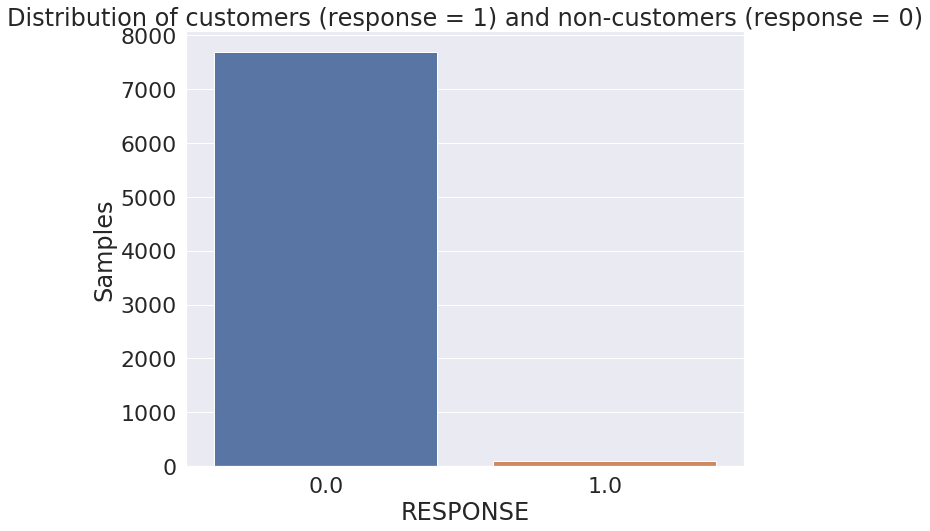

In [141]:
# the same in percent

sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(10,8))
g = sns.countplot(data = mailout_subset_na,
                  x = 'RESPONSE')

ax.set_ylabel('Samples')
ax.set_title('Distribution of customers (response = 1) and non-customers (response = 0)')

fig.savefig(Path('img/exploration').joinpath('imbalance_mailout_training'))

# one sees a significant drop between 6th first columns and the rest
# a ratio of nan around 65% should do it

In [81]:
test

0        0.029891
1        0.019022
2        0.035326
3        0.046196
4        0.035326
           ...   
42957    0.029891
42958    0.032609
42959    0.024457
42960    0.016304
42961    0.029891
Length: 42962, dtype: float64

In [38]:
mailout_samples

42962

## let's analyze the frequency of categories inside each column (most columns are categorical)

### Graphically

In [11]:
plt.ioff()
IMG_DIR = Path('img/exploration/frequency')
IMG_DIR.mkdir(exist_ok=True, parents=True)
for col in pop_df_selected.columns:
    x_labels = list(pop_df_selected[col].index)
    sns.set(font_scale=2)
    f, ax = plt.subplots(figsize=(10,5))
    series = pop_df_selected.loc[:,col].fillna('none').value_counts(normalize=True) # fillna is mandatory since seaborn discards np.nan
    try:
        g = sns.barplot(x = list(series.index) , y= series.values, 
                        palette="ch:.25", )
    except Exception:
        print(series)
        break
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    fig = g.get_figure()
    fig.savefig(IMG_DIR.joinpath(f'frequency_{col}'))

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


### Numerically

In [5]:
filename = 'DIAS Attributes - Values 2017.xlsx'

In [6]:
pop_df_numeric = identify_numeric_from_filename(filename, pop_df_selected) # based on Excel file
pop_df_cat = [col for col in pop_df_selected.columns if col not in pop_df_numeric]

In [7]:
for column in pop_df_cat:
    display(pd.crosstab(index=pop_df_selected[column], columns='% observations', normalize='columns'))

col_0,% observations
AGER_TYP,
-1,0.760440
0,0.009353
1,0.089441
2,0.110497
3,0.030269


col_0,% observations
AKT_DAT_KL,
1.0,0.476491
2.0,0.018317
3.0,0.030674
4.0,0.026342
5.0,0.035842
6.0,0.033489
7.0,0.025718
8.0,0.021794
9.0,0.331333


col_0,% observations
ALTER_HH,
0.0,0.290208
2.0,0.000063
3.0,0.000261
4.0,0.000695
5.0,0.001271
6.0,0.004886
7.0,0.010046
8.0,0.016248
9.0,0.027589


col_0,% observations
ALTER_KIND1,
2.0,0.005249
3.0,0.013123
4.0,0.013455
5.0,0.018011
6.0,0.059251
7.0,0.078107
8.0,0.078378
9.0,0.072043
10.0,0.067759


col_0,% observations
ALTER_KIND2,
3.0,0.000658
4.0,0.002466
5.0,0.005507
6.0,0.012329
7.0,0.020302
8.0,0.039536
9.0,0.054332
10.0,0.066990
11.0,0.085320


col_0,% observations
ALTER_KIND3,
5.0,0.000393
6.0,0.002356
7.0,0.006675
8.0,0.014134
9.0,0.022772
10.0,0.033373
11.0,0.061641
12.0,0.069494
13.0,0.109541


col_0,% observations
ALTER_KIND4,
7.0,0.001996
8.0,0.009980
9.0,0.015968
10.0,0.025948
11.0,0.043912
12.0,0.055888
13.0,0.091816
14.0,0.121756
15.0,0.153693


col_0,% observations
ALTERSKATEGORIE_FEIN,
0.0,0.065537
2.0,0.000129
3.0,0.000351
4.0,0.000988
5.0,0.001609
6.0,0.006154
7.0,0.013237
8.0,0.022956
9.0,0.041172


col_0,% observations
ANZ_KINDER,
0.0,0.893889
1.0,0.067667
2.0,0.030188
3.0,0.006634
4.0,0.001307
5.0,0.000246
6.0,0.000057
7.0,0.000009
9.0,0.000003


col_0,% observations
ANZ_STATISTISCHE_HAUSHALTE,
0.0,0.000061
1.0,0.275961
2.0,0.151808
3.0,0.077447
4.0,0.056289
5.0,0.050336
6.0,0.048106
7.0,0.045744
8.0,0.041075


col_0,% observations
ARBEIT,
1.0,0.071719
2.0,0.171924
3.0,0.322149
4.0,0.390327
5.0,0.043696
9.0,0.000185


col_0,% observations
BALLRAUM,
1.0,0.190367
2.0,0.131399
3.0,0.092122
4.0,0.077183
5.0,0.065801
6.0,0.319414
7.0,0.123714


col_0,% observations
CAMEO_DEU_2015,
1A,0.013842
1B,0.005120
1C,0.005331
1D,0.015231
1E,0.006435
2A,0.016800
2B,0.019668
2C,0.024556
2D,0.044350


col_0,% observations
CAMEO_DEUG_2015,
1.0,0.020166
2.0,0.046043
3.0,0.047908
4.0,0.057144
5.0,0.030493
6.0,0.057759
7.0,0.042575
8.0,0.074058
9.0,0.059028


col_0,% observations
CAMEO_INTL_2015,
12.0,0.007462
13.0,0.014860
14.0,0.034428
15.0,0.009458
22.0,0.018563
23.0,0.014813
24.0,0.050297
25.0,0.021379
31.0,0.010559


col_0,% observations
CJT_GESAMTTYP,
1.0,0.110637
2.0,0.168678
3.0,0.176501
4.0,0.238277
5.0,0.132695
6.0,0.173212


col_0,% observations
CJT_KATALOGNUTZER,
1.0,0.189692
2.0,0.119623
3.0,0.177110
4.0,0.196475
5.0,0.317100


col_0,% observations
CJT_TYP_1,
1.0,0.098340
2.0,0.221816
3.0,0.194551
4.0,0.183491
5.0,0.301802


col_0,% observations
CJT_TYP_2,
1.0,0.135347
2.0,0.232364
3.0,0.196314
4.0,0.173664
5.0,0.262312


col_0,% observations
CJT_TYP_3,
1.0,0.116472
2.0,0.205821
3.0,0.193250
4.0,0.180468
5.0,0.303989


col_0,% observations
CJT_TYP_4,
1.0,0.113823
2.0,0.203086
3.0,0.204409
4.0,0.192259
5.0,0.286424


col_0,% observations
CJT_TYP_5,
1.0,0.110634
2.0,0.196749
3.0,0.220601
4.0,0.166269
5.0,0.305747


col_0,% observations
CJT_TYP_6,
1.0,0.084202
2.0,0.198576
3.0,0.192630
4.0,0.218353
5.0,0.306240


col_0,% observations
D19_BANKEN_ANZ_12,
0,0.932750
1,0.033573
2,0.020363
3,0.006495
4,0.004631
5,0.001710
6,0.000479


col_0,% observations
D19_BANKEN_ANZ_24,
0,0.891157
1,0.048462
2,0.032909
3,0.011379
4,0.010080
5,0.004490
6,0.001523


col_0,% observations
D19_BANKEN_DATUM,
1,0.009694
2,0.008923
3,0.005663
4,0.009746
5,0.033223
6,0.018934
7,0.022659
8,0.037130
9,0.092596


col_0,% observations
D19_BANKEN_DIREKT,
0,0.817911
1,0.008268
2,0.009099
3,0.030737
4,0.009504
5,0.020652
6,0.095242
7,0.008587


col_0,% observations
D19_BANKEN_GROSS,
0,0.881444
1,0.007291
2,0.006244
3,0.016839
4,0.008942
5,0.015528
6,0.063712


col_0,% observations
D19_BANKEN_LOKAL,
0,0.981812
1,0.000011
2,0.000127
3,0.003888
4,0.000096
5,0.001170
6,0.003466
7,0.009430


col_0,% observations
D19_BANKEN_OFFLINE_DATUM,
1,0.000551
2,0.002225
3,0.000088
4,0.000330
5,0.004636
6,0.000562
7,0.000405
8,0.007139
9,0.005892


col_0,% observations
D19_BANKEN_ONLINE_DATUM,
1,0.007847
2,0.005608
3,0.004917
4,0.007935
5,0.024961
6,0.015088
7,0.018078
8,0.025966
9,0.074202


col_0,% observations
D19_BANKEN_ONLINE_QUOTE_12,
0.0,0.927996
2.0,0.000066
3.0,0.000348
4.0,0.000027
5.0,0.000615
6.0,0.000062
7.0,0.000309
8.0,0.000247
9.0,0.000108


col_0,% observations
D19_BANKEN_REST,
0,0.921814
1,0.001027
2,0.003362
3,0.006839
4,0.001572
5,0.008722
6,0.048440
7,0.008224


col_0,% observations
D19_BEKLEIDUNG_GEH,
0,0.907828
1,0.002048
2,0.003656
3,0.017293
4,0.002263
5,0.013270
6,0.044084
7,0.009556


col_0,% observations
D19_BEKLEIDUNG_REST,
0,0.776508
1,0.008125
2,0.009939
3,0.034019
4,0.005864
5,0.020823
6,0.122507
7,0.022216


col_0,% observations
D19_BILDUNG,
0,0.912544
1,0.000432
2,0.009658
3,0.005823
4,0.001388
5,0.003769
6,0.042116
7,0.024270


col_0,% observations
D19_BIO_OEKO,
0,0.958583
2,0.000050
3,0.002090
4,0.000094
5,0.002360
6,0.019928
7,0.016896


col_0,% observations
D19_BUCH_CD,
0,0.697895
1,0.013204
2,0.010481
3,0.029462
4,0.009468
5,0.018171
6,0.211411
7,0.009906


col_0,% observations
D19_DIGIT_SERV,
0,0.962768
1,0.000476
2,0.001423
3,0.006853
4,0.000465
5,0.003629
6,0.019964
7,0.004422


col_0,% observations
D19_DROGERIEARTIKEL,
0,0.853119
1,0.007993
2,0.010947
3,0.028256
4,0.012588
5,0.019501
6,0.058883
7,0.008714


col_0,% observations
D19_ENERGIE,
0,0.931817
1,0.000724
2,0.002098
3,0.016233
4,0.001333
5,0.010790
6,0.028372
7,0.008634


col_0,% observations
D19_FREIZEIT,
0,0.886843
1,0.001550
2,0.002927
3,0.017092
4,0.004427
5,0.015539
6,0.061867
7,0.009755


col_0,% observations
D19_GARTEN,
0,0.955541
1,0.000055
2,0.000306
3,0.004617
4,0.000396
5,0.005471
6,0.022926
7,0.010688


col_0,% observations
D19_GESAMT_ANZ_12,
0,0.655953
1,0.111067
2,0.109459
3,0.051259
4,0.049101
5,0.019289
6,0.003871


col_0,% observations
D19_GESAMT_ANZ_24,
0,0.566812
1,0.096707
2,0.114170
3,0.065890
4,0.083420
5,0.052317
6,0.020685


col_0,% observations
D19_GESAMT_DATUM,
1,0.085234
2,0.067429
3,0.036777
4,0.049519
5,0.105087
6,0.047168
7,0.041973
8,0.059511
9,0.110082


col_0,% observations
D19_GESAMT_OFFLINE_DATUM,
1,0.007131
2,0.010421
3,0.006098
4,0.010446
5,0.038917
6,0.025418
7,0.031202
8,0.077875
9,0.165730


col_0,% observations
D19_GESAMT_ONLINE_DATUM,
1,0.064299
2,0.046427
3,0.029619
4,0.040910
5,0.089328
6,0.041105
7,0.037592
8,0.048027
9,0.096919


col_0,% observations
D19_GESAMT_ONLINE_QUOTE_12,
0.0,0.619989
1.0,0.001319
2.0,0.001620
3.0,0.005595
4.0,0.001616
5.0,0.016465
6.0,0.002598
7.0,0.011082
8.0,0.015011


col_0,% observations
D19_HANDWERK,
0,0.862111
1,0.000008
2,0.000105
3,0.002728
4,0.000190
5,0.004347
6,0.101850
7,0.028661


col_0,% observations
D19_HAUS_DEKO,
0,0.799211
1,0.004656
2,0.008502
3,0.035092
4,0.004389
5,0.023311
6,0.113275
7,0.011563


col_0,% observations
D19_KINDERARTIKEL,
0,0.840542
1,0.001195
2,0.006484
3,0.018408
4,0.003698
5,0.014895
6,0.089262
7,0.025517


col_0,% observations
D19_KONSUMTYP,
1.0,0.186442
2.0,0.077924
3.0,0.083628
4.0,0.124113
5.0,0.038301
6.0,0.088759
9.0,0.400834


col_0,% observations
D19_KONSUMTYP_MAX,
1,0.162759
2,0.102546
3,0.069739
4,0.084992
8,0.291975
9,0.287989


col_0,% observations
D19_KOSMETIK,
0,0.836674
1,0.000124
2,0.000278
3,0.001440
4,0.000322
5,0.001440
6,0.100374
7,0.059348


col_0,% observations
D19_LEBENSMITTEL,
0,0.940778
1,0.000421
2,0.001462
3,0.011269
4,0.000523
5,0.005694
6,0.030781
7,0.009072


col_0,% observations
D19_LETZTER_KAUF_BRANCHE,
D19_BANKEN_DIREKT,0.036766
D19_BANKEN_GROSS,0.016693
D19_BANKEN_LOKAL,0.002239
D19_BANKEN_REST,0.008391
D19_BEKLEIDUNG_GEH,0.016631
D19_BEKLEIDUNG_REST,0.034589
D19_BILDUNG,0.001466
D19_BIO_OEKO,0.001949
D19_BUCH_CD,0.045126


col_0,% observations
D19_LOTTO,
0.0,0.773474
1.0,0.000031
2.0,0.000093
3.0,0.002947
4.0,0.000143
5.0,0.003163
6.0,0.040238
7.0,0.179911


col_0,% observations
D19_NAHRUNGSERGAENZUNG,
0,0.956326
1,0.000672
2,0.000735
3,0.006437
4,0.000468
5,0.004694
6,0.017733
7,0.012935


col_0,% observations
D19_RATGEBER,
0,0.902718
1,0.000950
2,0.009342
3,0.012048
4,0.002362
5,0.008375
6,0.050219
7,0.013986


col_0,% observations
D19_REISEN,
0,0.826671
1,0.000107
2,0.003356
3,0.006454
4,0.001005
5,0.005785
6,0.104966
7,0.051656


col_0,% observations
D19_SAMMELARTIKEL,
0,0.900014
1,0.000047
2,0.000206
3,0.003260
4,0.000556
5,0.004557
6,0.080107
7,0.011252


col_0,% observations
D19_SCHUHE,
0,0.867034
1,0.005743
2,0.019493
3,0.051931
4,0.003882
5,0.022414
6,0.023245
7,0.006258


col_0,% observations
D19_SONSTIGE,
0,0.567145
1,0.006418
2,0.012037
3,0.049830
4,0.011316
5,0.039393
6,0.248221
7,0.065639


col_0,% observations
D19_SOZIALES,
0.0,0.797039
1.0,0.040238
2.0,0.023282
3.0,0.033920
4.0,0.057530
5.0,0.047991


col_0,% observations
D19_TECHNIK,
0,0.706304
1,0.000592
2,0.001264
3,0.012296
4,0.002026
5,0.016203
6,0.214916
7,0.046400


col_0,% observations
D19_TELKO_ANZ_12,
0,0.962804
1,0.027796
2,0.007764
3,0.001005
4,0.000465
5,0.000121
6,0.000044


col_0,% observations
D19_TELKO_ANZ_24,
0,0.927120
1,0.052022
2,0.017276
3,0.002351
4,0.000955
5,0.000218
6,0.000058


col_0,% observations
D19_TELKO_DATUM,
1,0.003353
2,0.003282
3,0.002808
4,0.005994
5,0.021759
6,0.015156
7,0.020528
8,0.047441
9,0.132551


col_0,% observations
D19_TELKO_MOBILE,
0,0.816030
1,0.002194
2,0.003970
3,0.018372
4,0.003978
5,0.015801
6,0.130626
7,0.009028


col_0,% observations
D19_TELKO_OFFLINE_DATUM,
1,0.000754
2,0.000628
3,0.000625
4,0.001255
5,0.007062
6,0.004367
7,0.004055
8,0.020971
9,0.040632


col_0,% observations
D19_TELKO_ONLINE_DATUM,
1,0.000074
2,0.000044
3,0.000063
4,0.000140
5,0.000595
6,0.000485
7,0.000661
8,0.001922
9,0.005256


col_0,% observations
D19_TELKO_ONLINE_QUOTE_12,
0.0,0.998712
3.0,0.000004
5.0,0.000031
10.0,0.001253


col_0,% observations
D19_TELKO_REST,
0,0.859440
1,0.000463
2,0.001605
3,0.012866
4,0.002679
5,0.017354
6,0.098986
7,0.006608


col_0,% observations
D19_TIERARTIKEL,
0,0.956128
1,0.000030
2,0.000617
3,0.006883
4,0.000498
5,0.004265
6,0.022513
7,0.009066


col_0,% observations
D19_VERSAND_ANZ_12,
0,0.716188
1,0.107496
2,0.091627
3,0.038760
4,0.033033
5,0.011054
6,0.001842


col_0,% observations
D19_VERSAND_ANZ_24,
0,0.632823
1,0.100795
2,0.104908
3,0.053798
4,0.061823
5,0.034308
6,0.011544


col_0,% observations
D19_VERSAND_DATUM,
1,0.060461
2,0.046240
3,0.028386
4,0.038385
5,0.087841
6,0.041634
7,0.036139
8,0.056562
9,0.113642


col_0,% observations
D19_VERSAND_OFFLINE_DATUM,
1,0.003967
2,0.005699
3,0.003709
4,0.005862
5,0.025308
6,0.017475
7,0.022130
8,0.064772
9,0.139527


col_0,% observations
D19_VERSAND_ONLINE_DATUM,
1,0.055783
2,0.041469
3,0.026098
4,0.035594
5,0.079243
6,0.038038
7,0.033424
8,0.043033
9,0.092957


col_0,% observations
D19_VERSAND_ONLINE_QUOTE_12,
0.0,0.658518
1.0,0.000851
2.0,0.001195
3.0,0.004037
4.0,0.001172
5.0,0.012447
6.0,0.001682
7.0,0.007997
8.0,0.010266


col_0,% observations
D19_VERSAND_REST,
0,0.824262
1,0.005308
2,0.008513
3,0.044098
4,0.005498
5,0.028413
6,0.077492
7,0.006415


col_0,% observations
D19_VERSI_ANZ_12,
0,0.921035
1,0.050833
2,0.022898
3,0.003651
4,0.001363
5,0.000209
6,0.000011


col_0,% observations
D19_VERSI_ANZ_24,
0,0.871882
1,0.071242
2,0.041430
3,0.010077
4,0.004490
5,0.000776
6,0.000102


col_0,% observations
D19_VERSI_DATUM,
1,0.009733
2,0.018056
3,0.007602
4,0.011002
5,0.032573
6,0.025701
7,0.023452
8,0.040979
9,0.090058


col_0,% observations
D19_VERSI_OFFLINE_DATUM,
1,0.000179
2,0.000231
3,0.000206
4,0.000570
5,0.003766
6,0.001732
7,0.002092
8,0.007998
9,0.020143


col_0,% observations
D19_VERSI_ONLINE_DATUM,
1,0.000107
2,0.000149
3,0.000151
4,0.000344
5,0.001035
6,0.000754
7,0.001200
8,0.001418
9,0.003029


col_0,% observations
D19_VERSI_ONLINE_QUOTE_12,
0.0,0.997490
3.0,0.000012
5.0,0.000112
7.0,0.000019
8.0,0.000015
9.0,0.000004
10.0,0.002347


col_0,% observations
D19_VERSICHERUNGEN,
0,0.734340
1,0.011294
2,0.016839
3,0.050833
4,0.014856
5,0.034297
6,0.131036
7,0.006506


col_0,% observations
D19_VOLLSORTIMENT,
0,0.673083
1,0.004452
2,0.009179
3,0.049949
4,0.007073
5,0.034847
6,0.195354
7,0.026062


col_0,% observations
D19_WEIN_FEINKOST,
0,0.938474
1,0.000030
2,0.000204
3,0.003808
4,0.000273
5,0.003241
6,0.031103
7,0.022868


col_0,% observations
DSL_FLAG,
0.0,0.031795
1.0,0.968205


col_0,% observations
EINGEFUEGT_AM,
1991-08-30 00:00:00,0.000006
1992-02-10 00:00:00,0.481250
1992-02-12 00:00:00,0.240928
1992-02-19 00:00:00,0.000415
1992-02-21 00:00:00,0.002725
1992-12-14 00:00:00,0.000018
1992-12-17 00:00:00,0.000009
1992-12-18 00:00:00,0.000018
1992-12-22 00:00:00,0.000249


col_0,% observations
EINGEZOGENAM_HH_JAHR,
1900.0,0.000003
1904.0,0.000003
1986.0,0.000006
1987.0,0.000024
1988.0,0.000030
1989.0,0.000084
1990.0,0.000204
1991.0,0.000276
1992.0,0.000695


col_0,% observations
EWDICHTE,
1.0,0.104786
2.0,0.175148
3.0,0.102490
4.0,0.163532
5.0,0.202302
6.0,0.251741


col_0,% observations
EXTSEL992,
1.0,0.006633
2.0,0.011848
3.0,0.011559
4.0,0.006229
5.0,0.006002
6.0,0.020292
7.0,0.002349
8.0,0.002784
9.0,0.004077


col_0,% observations
FINANZ_ANLEGER,
1,0.236724
2,0.181423
3,0.158681
4,0.160782
5,0.262389


col_0,% observations
FINANZ_HAUSBAUER,
1,0.161358
2,0.193914
3,0.263945
4,0.176021
5,0.204762


col_0,% observations
FINANZ_MINIMALIST,
1,0.156713
2,0.179055
3,0.285803
4,0.188276
5,0.190153


col_0,% observations
FINANZ_SPARER,
1,0.280239
2,0.172109
3,0.157767
4,0.225056
5,0.164829


col_0,% observations
FINANZ_UNAUFFAELLIGER,
1,0.246060
2,0.208520
3,0.191976
4,0.128286
5,0.225158


col_0,% observations
FINANZ_VORSORGER,
1,0.117111
2,0.130634
3,0.256820
4,0.223971
5,0.271464


col_0,% observations
FINANZTYP,
1,0.225205
2,0.124930
3,0.059998
4,0.145728
5,0.119880
6,0.324260


col_0,% observations
FIRMENDICHTE,
1.0,0.055869
2.0,0.173730
3.0,0.226693
4.0,0.344004
5.0,0.199704


col_0,% observations
GEBAEUDETYP,
1.0,0.577294
2.0,0.006076
3.0,0.223539
4.0,0.001121
6.0,0.000808
8.0,0.191163


col_0,% observations
GEBAEUDETYP_RASTER,
1.0,0.018600
2.0,0.073646
3.0,0.257454
4.0,0.450597
5.0,0.199704


col_0,% observations
GEMEINDETYP,
11.0,0.189878
12.0,0.150555
21.0,0.091497
22.0,0.190903
30.0,0.155091
40.0,0.157814
50.0,0.064263


col_0,% observations
GFK_URLAUBERTYP,
1.0,0.060981
2.0,0.052283
3.0,0.062850
4.0,0.072121
5.0,0.134879
6.0,0.031188
7.0,0.048618
8.0,0.099718
9.0,0.067858


col_0,% observations
GREEN_AVANTGARDE,
0,0.801997
1,0.198003


col_0,% observations
HEALTH_TYP,
-1,0.124082
1,0.182403
2,0.344025
3,0.349490


col_0,% observations
HH_DELTA_FLAG,
0.0,0.906896
1.0,0.093104


col_0,% observations
HH_EINKOMMEN_SCORE,
1.0,0.061455
2.0,0.161012
3.0,0.097390
4.0,0.160352
5.0,0.231027
6.0,0.288763


col_0,% observations
INNENSTADT,
1.0,0.064953
2.0,0.136163
3.0,0.116823
4.0,0.168623
5.0,0.184769
6.0,0.140439
7.0,0.084938
8.0,0.103292


col_0,% observations
KBA05_ALTER1,
0.0,0.135381
1.0,0.221529
2.0,0.301579
3.0,0.218670
4.0,0.103179
9.0,0.019662


col_0,% observations
KBA05_ALTER2,
1.0,0.074773
2.0,0.218422
3.0,0.380691
4.0,0.211279
5.0,0.095173
9.0,0.019662


col_0,% observations
KBA05_ALTER3,
1.0,0.090080
2.0,0.208951
3.0,0.386149
4.0,0.206244
5.0,0.088913
9.0,0.019662


col_0,% observations
KBA05_ALTER4,
0.0,0.065842
1.0,0.074647
2.0,0.183125
3.0,0.394792
4.0,0.190365
5.0,0.071566
9.0,0.019662


col_0,% observations
KBA05_ANHANG,
0.0,0.349806
1.0,0.427385
2.0,0.095668
3.0,0.108653
9.0,0.018489


col_0,% observations
KBA05_ANTG1,
0.0,0.342850
1.0,0.212760
2.0,0.167986
3.0,0.155596
4.0,0.120807


col_0,% observations
KBA05_ANTG2,
0.0,0.384888
1.0,0.217099
2.0,0.182802
3.0,0.177286
4.0,0.037925


col_0,% observations
KBA05_ANTG3,
0.0,0.676136
1.0,0.122026
2.0,0.105620
3.0,0.096217


col_0,% observations
KBA05_ANTG4,
0.0,0.792902
1.0,0.109956
2.0,0.097142


col_0,% observations
KBA05_AUTOQUOT,
1.0,0.110748
2.0,0.162764
3.0,0.340089
4.0,0.257145
5.0,0.109587
9.0,0.019666


col_0,% observations
KBA05_BAUMAX,
0.0,0.452490
1.0,0.275850
2.0,0.012869
3.0,0.078469
4.0,0.049216
5.0,0.131106


col_0,% observations
KBA05_CCM1,
1.0,0.089256
2.0,0.225613
3.0,0.384177
4.0,0.195584
5.0,0.085709
9.0,0.019662


col_0,% observations
KBA05_CCM2,
1.0,0.082152
2.0,0.207881
3.0,0.397492
4.0,0.215169
5.0,0.077644
9.0,0.019662


col_0,% observations
KBA05_CCM3,
1.0,0.086682
2.0,0.202972
3.0,0.377445
4.0,0.219508
5.0,0.093731
9.0,0.019662


col_0,% observations
KBA05_CCM4,
0.0,0.360686
1.0,0.283782
2.0,0.169600
3.0,0.103741
4.0,0.062528
9.0,0.019662


col_0,% observations
KBA05_DIESEL,
0.0,0.084570
1.0,0.204130
2.0,0.389092
3.0,0.216805
4.0,0.085741
9.0,0.019662


col_0,% observations
KBA05_FRAU,
1.0,0.091461
2.0,0.202578
3.0,0.400150
4.0,0.194093
5.0,0.092056
9.0,0.019662


col_0,% observations
KBA05_GBZ,
1.0,0.140978
2.0,0.182165
3.0,0.261058
4.0,0.206358
5.0,0.209442


col_0,% observations
KBA05_HERST1,
0.0,0.098248
1.0,0.156786
2.0,0.298594
3.0,0.233774
4.0,0.115608
5.0,0.077328
9.0,0.019662


col_0,% observations
KBA05_HERST2,
1.0,0.072969
2.0,0.227009
3.0,0.398957
4.0,0.201549
5.0,0.079853
9.0,0.019662


col_0,% observations
KBA05_HERST3,
0.0,0.022020
1.0,0.079630
2.0,0.210183
3.0,0.393906
4.0,0.194565
5.0,0.080034
9.0,0.019662


col_0,% observations
KBA05_HERST4,
0.0,0.040641
1.0,0.099127
2.0,0.216595
3.0,0.343044
4.0,0.187306
5.0,0.093624
9.0,0.019662


col_0,% observations
KBA05_HERST5,
0.0,0.062373
1.0,0.085573
2.0,0.218001
3.0,0.320478
4.0,0.209303
5.0,0.084609
9.0,0.019662


col_0,% observations
KBA05_HERSTTEMP,
1.0,0.203824
2.0,0.198513
3.0,0.344135
4.0,0.150751
5.0,0.081705
9.0,0.021072


col_0,% observations
KBA05_KRSAQUOT,
1.0,0.110609
2.0,0.199930
3.0,0.373917
4.0,0.188878
5.0,0.107004
9.0,0.019662


col_0,% observations
KBA05_KRSHERST1,
1.0,0.083206
2.0,0.231368
3.0,0.395125
4.0,0.212178
5.0,0.058460
9.0,0.019662


col_0,% observations
KBA05_KRSHERST2,
1.0,0.094940
2.0,0.210141
3.0,0.394158
4.0,0.201278
5.0,0.079820
9.0,0.019662


col_0,% observations
KBA05_KRSHERST3,
1.0,0.085667
2.0,0.203583
3.0,0.387378
4.0,0.194973
5.0,0.108737
9.0,0.019662


col_0,% observations
KBA05_KRSKLEIN,
1.0,0.206442
2.0,0.575425
3.0,0.198471
9.0,0.019662


col_0,% observations
KBA05_KRSOBER,
1.0,0.201035
2.0,0.612418
3.0,0.166884
9.0,0.019662


col_0,% observations
KBA05_KRSVAN,
1.0,0.167262
2.0,0.647685
3.0,0.165390
9.0,0.019662


col_0,% observations
KBA05_KRSZUL,
1.0,0.273652
2.0,0.502388
3.0,0.204298
9.0,0.019662


col_0,% observations
KBA05_KW1,
1.0,0.103046
2.0,0.211874
3.0,0.362849
4.0,0.211835
5.0,0.090733
9.0,0.019662


col_0,% observations
KBA05_KW2,
1.0,0.084816
2.0,0.205274
3.0,0.404046
4.0,0.200547
5.0,0.085654
9.0,0.019662


col_0,% observations
KBA05_KW3,
0.0,0.272145
1.0,0.307842
2.0,0.212679
3.0,0.105956
4.0,0.081715
9.0,0.019662


col_0,% observations
KBA05_MAXAH,
1.0,0.067149
2.0,0.245288
3.0,0.275252
4.0,0.135361
5.0,0.257287
9.0,0.019662


col_0,% observations
KBA05_MAXBJ,
1.0,0.339016
2.0,0.240839
3.0,0.152631
4.0,0.247852
9.0,0.019662


col_0,% observations
KBA05_MAXHERST,
1.0,0.107570
2.0,0.358497
3.0,0.276775
4.0,0.153349
5.0,0.084147
9.0,0.019662


col_0,% observations
KBA05_MAXSEG,
1.0,0.268524
2.0,0.393218
3.0,0.227265
4.0,0.091331
9.0,0.019662


col_0,% observations
KBA05_MAXVORB,
1.0,0.236377
2.0,0.427388
3.0,0.316572
9.0,0.019662


col_0,% observations
KBA05_MOD1,
0.0,0.376769
1.0,0.185929
2.0,0.238446
3.0,0.116319
4.0,0.062874
9.0,0.019662


col_0,% observations
KBA05_MOD2,
1.0,0.086449
2.0,0.211673
3.0,0.397935
4.0,0.207745
5.0,0.076535
9.0,0.019662


col_0,% observations
KBA05_MOD3,
1.0,0.088851
2.0,0.226117
3.0,0.365433
4.0,0.218076
5.0,0.081861
9.0,0.019662


col_0,% observations
KBA05_MOD4,
0.0,0.066693
1.0,0.127892
2.0,0.211483
3.0,0.294491
4.0,0.172710
5.0,0.107069
9.0,0.019662


col_0,% observations
KBA05_MOD8,
0.0,0.292794
1.0,0.285354
2.0,0.286391
3.0,0.115799
9.0,0.019662


col_0,% observations
KBA05_MODTEMP,
1.0,0.190379
2.0,0.096879
3.0,0.335294
4.0,0.283852
5.0,0.081705
6.0,0.011891


col_0,% observations
KBA05_MOTOR,
1.0,0.158804
2.0,0.292289
3.0,0.384083
4.0,0.145162
9.0,0.019662


col_0,% observations
KBA05_MOTRAD,
0.0,0.269080
1.0,0.517229
2.0,0.097330
3.0,0.098823
9.0,0.017538


col_0,% observations
KBA05_SEG1,
0.0,0.323786
1.0,0.331763
2.0,0.246303
3.0,0.078485
9.0,0.019662


col_0,% observations
KBA05_SEG10,
0.0,0.146795
1.0,0.200269
2.0,0.352686
3.0,0.196557
4.0,0.084030
9.0,0.019662


col_0,% observations
KBA05_SEG2,
1.0,0.091629
2.0,0.201585
3.0,0.396160
4.0,0.215835
5.0,0.075129
9.0,0.019662


col_0,% observations
KBA05_SEG3,
1.0,0.082352
2.0,0.244173
3.0,0.358018
4.0,0.215796
5.0,0.079998
9.0,0.019662


col_0,% observations
KBA05_SEG4,
1.0,0.081761
2.0,0.200951
3.0,0.426619
4.0,0.189140
5.0,0.081867
9.0,0.019662


col_0,% observations
KBA05_SEG5,
0.0,0.240522
1.0,0.310697
2.0,0.241990
3.0,0.120099
4.0,0.067029
9.0,0.019662


col_0,% observations
KBA05_SEG6,
0.0,0.862666
1.0,0.117671
9.0,0.019662


col_0,% observations
KBA05_SEG7,
0.0,0.485260
1.0,0.242093
2.0,0.187190
3.0,0.065794
9.0,0.019662


col_0,% observations
KBA05_SEG8,
0.0,0.531728
1.0,0.228985
2.0,0.159185
3.0,0.060439
9.0,0.019662


col_0,% observations
KBA05_SEG9,
0.0,0.340008
1.0,0.316834
2.0,0.248366
3.0,0.075129
9.0,0.019662


col_0,% observations
KBA05_VORB0,
1.0,0.140819
2.0,0.228384
3.0,0.321966
4.0,0.213862
5.0,0.075307
9.0,0.019662


col_0,% observations
KBA05_VORB1,
1.0,0.085408
2.0,0.203056
3.0,0.409676
4.0,0.195681
5.0,0.086517
9.0,0.019662


col_0,% observations
KBA05_VORB2,
0.0,0.071889
1.0,0.110444
2.0,0.212498
3.0,0.309911
4.0,0.159369
5.0,0.116226
9.0,0.019662


col_0,% observations
KBA05_ZUL1,
1.0,0.089298
2.0,0.207347
3.0,0.394779
4.0,0.208721
5.0,0.080192
9.0,0.019662


col_0,% observations
KBA05_ZUL2,
1.0,0.085295
2.0,0.219912
3.0,0.381040
4.0,0.210671
5.0,0.083419
9.0,0.019662


col_0,% observations
KBA05_ZUL3,
0.0,0.093275
1.0,0.097815
2.0,0.212129
3.0,0.296108
4.0,0.207053
5.0,0.073958
9.0,0.019662


col_0,% observations
KBA05_ZUL4,
0.0,0.138617
1.0,0.229933
2.0,0.241634
3.0,0.166392
4.0,0.132144
5.0,0.071617
9.0,0.019662


col_0,% observations
KBA13_ALTERHALTER_30,
1.0,0.092765
2.0,0.205875
3.0,0.425431
4.0,0.185845
5.0,0.090083


col_0,% observations
KBA13_ALTERHALTER_45,
1.0,0.088722
2.0,0.190881
3.0,0.389888
4.0,0.206194
5.0,0.124315


col_0,% observations
KBA13_ALTERHALTER_60,
1.0,0.119230
2.0,0.239283
3.0,0.410334
4.0,0.165999
5.0,0.065155


col_0,% observations
KBA13_ALTERHALTER_61,
1.0,0.075560
2.0,0.175927
3.0,0.411451
4.0,0.226496
5.0,0.110566


col_0,% observations
KBA13_ANTG1,
0.0,0.009918
1.0,0.254415
2.0,0.381131
3.0,0.280483
4.0,0.074052


col_0,% observations
KBA13_ANTG2,
0.0,0.013402
1.0,0.073603
2.0,0.265183
3.0,0.415032
4.0,0.232780


col_0,% observations
KBA13_ANTG3,
0.0,0.170938
1.0,0.281189
2.0,0.321771
3.0,0.226102


col_0,% observations
KBA13_ANTG4,
0.0,0.485803
1.0,0.354076
2.0,0.160121


col_0,% observations
KBA13_AUDI,
1.0,0.072032
2.0,0.206288
3.0,0.441397
4.0,0.202732
5.0,0.077552


col_0,% observations
KBA13_AUTOQUOTE,
0.0,0.000006
1.0,0.128967
2.0,0.236470
3.0,0.411692
4.0,0.166642
5.0,0.056223


col_0,% observations
KBA13_BAUMAX,
1.0,0.626493
2.0,0.088831
3.0,0.074377
4.0,0.063800
5.0,0.146500


col_0,% observations
KBA13_BJ_1999,
1.0,0.064786
2.0,0.212319
3.0,0.456910
4.0,0.203147
5.0,0.062838


col_0,% observations
KBA13_BJ_2000,
1.0,0.073381
2.0,0.209547
3.0,0.442105
4.0,0.203331
5.0,0.071636


col_0,% observations
KBA13_BJ_2004,
1.0,0.062754
2.0,0.210003
3.0,0.466357
4.0,0.201445
5.0,0.059441


col_0,% observations
KBA13_BJ_2006,
1.0,0.066023
2.0,0.212094
3.0,0.455483
4.0,0.204689
5.0,0.061711


col_0,% observations
KBA13_BJ_2008,
0.0,0.170910
1.0,0.063113
2.0,0.216743
3.0,0.350724
4.0,0.109345
5.0,0.089165


col_0,% observations
KBA13_BJ_2009,
0.0,0.128561
1.0,0.153009
2.0,0.149612
3.0,0.364666
4.0,0.112599
5.0,0.091554


col_0,% observations
KBA13_BMW,
1.0,0.049283
2.0,0.177494
3.0,0.440807
4.0,0.226015
5.0,0.106402


col_0,% observations
KBA13_CCM_0_1400,
0.0,0.176489
1.0,0.076734
2.0,0.227798
3.0,0.341024
4.0,0.103910
5.0,0.074046


col_0,% observations
KBA13_CCM_1000,
0.0,0.131789
1.0,0.152141
2.0,0.151847
3.0,0.370626
4.0,0.108877
5.0,0.084720


col_0,% observations
KBA13_CCM_1200,
0.0,0.186763
1.0,0.078120
2.0,0.205385
3.0,0.354617
4.0,0.103454
5.0,0.071661


col_0,% observations
KBA13_CCM_1400,
1.0,0.054634
2.0,0.216362
3.0,0.461408
4.0,0.205382
5.0,0.062214


col_0,% observations
KBA13_CCM_1401_2500,
1.0,0.077418
2.0,0.221242
3.0,0.458018
4.0,0.201146
5.0,0.042177


col_0,% observations
KBA13_CCM_1500,
1.0,0.366561
2.0,0.084729
3.0,0.200156
4.0,0.262089
5.0,0.086465


col_0,% observations
KBA13_CCM_1600,
1.0,0.049167
2.0,0.213977
3.0,0.463459
4.0,0.207499
5.0,0.065898


col_0,% observations
KBA13_CCM_1800,
0.0,0.175390
1.0,0.066060
2.0,0.229571
3.0,0.351947
4.0,0.103810
5.0,0.073222


col_0,% observations
KBA13_CCM_2000,
1.0,0.042758
2.0,0.203787
3.0,0.462813
4.0,0.217901
5.0,0.072741


col_0,% observations
KBA13_CCM_2500,
0.0,0.121196
1.0,0.130237
2.0,0.182773
3.0,0.362331
4.0,0.113716
5.0,0.089746


col_0,% observations
KBA13_CCM_2501,
0.0,0.118980
1.0,0.154005
2.0,0.135317
3.0,0.375977
4.0,0.116410
5.0,0.099312


col_0,% observations
KBA13_CCM_3000,
0.0,0.072391
1.0,0.189036
2.0,0.131433
3.0,0.392748
4.0,0.117322
5.0,0.097070


col_0,% observations
KBA13_CCM_3001,
1.0,0.429243
2.0,0.000131
3.0,0.188452
4.0,0.275045
5.0,0.107129


col_0,% observations
KBA13_FAB_ASIEN,
1.0,0.079681
2.0,0.216524
3.0,0.433864
4.0,0.192826
5.0,0.077105


col_0,% observations
KBA13_FAB_SONSTIGE,
1.0,0.074758
2.0,0.213371
3.0,0.440638
4.0,0.194090
5.0,0.077143


col_0,% observations
KBA13_FIAT,
1.0,0.051534
2.0,0.187412
3.0,0.438412
4.0,0.221885
5.0,0.100757


col_0,% observations
KBA13_FORD,
1.0,0.081532
2.0,0.206753
3.0,0.426630
4.0,0.197000
5.0,0.088085


col_0,% observations
KBA13_GBZ,
1.0,0.049860
2.0,0.139001
3.0,0.362016
4.0,0.235165
5.0,0.213958


col_0,% observations
KBA13_HALTER_20,
1.0,0.084923
2.0,0.235009
3.0,0.430985
4.0,0.186139
5.0,0.062944


col_0,% observations
KBA13_HALTER_25,
1.0,0.093261
2.0,0.210980
3.0,0.435384
4.0,0.183201
5.0,0.077174


col_0,% observations
KBA13_HALTER_30,
1.0,0.084404
2.0,0.198767
3.0,0.411133
4.0,0.190285
5.0,0.115411


col_0,% observations
KBA13_HALTER_35,
1.0,0.081776
2.0,0.191914
3.0,0.393722
4.0,0.204739
5.0,0.127849


col_0,% observations
KBA13_HALTER_40,
1.0,0.081457
2.0,0.193700
3.0,0.399838
4.0,0.203181
5.0,0.121824


col_0,% observations
KBA13_HALTER_45,
1.0,0.087470
2.0,0.201096
3.0,0.405363
4.0,0.204983
5.0,0.101088


col_0,% observations
KBA13_HALTER_50,
1.0,0.114035
2.0,0.233664
3.0,0.414042
4.0,0.169976
5.0,0.068283


col_0,% observations
KBA13_HALTER_55,
1.0,0.117659
2.0,0.233629
3.0,0.407518
4.0,0.172515
5.0,0.068679


col_0,% observations
KBA13_HALTER_60,
1.0,0.113095
2.0,0.220046
3.0,0.409769
4.0,0.179377
5.0,0.077714


col_0,% observations
KBA13_HALTER_65,
1.0,0.066972
2.0,0.177891
3.0,0.422606
4.0,0.223461
5.0,0.109071


col_0,% observations
KBA13_HALTER_66,
1.0,0.080820
2.0,0.177650
3.0,0.408183
4.0,0.223633
5.0,0.109714


col_0,% observations
KBA13_HERST_ASIEN,
1.0,0.078851
2.0,0.208492
3.0,0.431903
4.0,0.195551
5.0,0.085204


col_0,% observations
KBA13_HERST_AUDI_VW,
1.0,0.092106
2.0,0.219109
3.0,0.427919
4.0,0.191287
5.0,0.069578


col_0,% observations
KBA13_HERST_BMW_BENZ,
1.0,0.057150
2.0,0.167888
3.0,0.433923
4.0,0.229146
5.0,0.111893


col_0,% observations
KBA13_HERST_EUROPA,
1.0,0.063160
2.0,0.192754
3.0,0.434644
4.0,0.216796
5.0,0.092646


col_0,% observations
KBA13_HERST_FORD_OPEL,
1.0,0.095159
2.0,0.209013
3.0,0.415023
4.0,0.195929
5.0,0.084876


col_0,% observations
KBA13_HERST_SONST,
1.0,0.074758
2.0,0.213371
3.0,0.440638
4.0,0.194090
5.0,0.077143


col_0,% observations
KBA13_HHZ,
1.0,0.016652
2.0,0.091160
3.0,0.408086
4.0,0.269098
5.0,0.215004


col_0,% observations
KBA13_KMH_0_140,
0.0,0.123235
1.0,0.297769
2.0,0.008407
3.0,0.360327
4.0,0.118102
5.0,0.092159


col_0,% observations
KBA13_KMH_110,
1.0,0.799391
2.0,0.080867
3.0,0.119742


col_0,% observations
KBA13_KMH_140,
1.0,0.316798
2.0,0.116810
3.0,0.213618
4.0,0.257206
5.0,0.095568


col_0,% observations
KBA13_KMH_140_210,
1.0,0.094479
2.0,0.229340
3.0,0.459132
4.0,0.169805
5.0,0.047244


col_0,% observations
KBA13_KMH_180,
1.0,0.078785
2.0,0.216977
3.0,0.451743
4.0,0.198629
5.0,0.053866


col_0,% observations
KBA13_KMH_210,
1.0,0.053813
2.0,0.206422
3.0,0.459111
4.0,0.210137
5.0,0.070518


col_0,% observations
KBA13_KMH_211,
0.0,0.177369
1.0,0.053460
2.0,0.206865
3.0,0.352572
4.0,0.112770
5.0,0.096964


col_0,% observations
KBA13_KMH_250,
0.0,0.178056
1.0,0.053510
2.0,0.205947
3.0,0.353618
4.0,0.113057
5.0,0.095812


col_0,% observations
KBA13_KMH_251,
1.0,0.858427
2.0,0.012756
3.0,0.128817


col_0,% observations
KBA13_KRSAQUOT,
0.0,0.000066
1.0,0.116573
2.0,0.219056
3.0,0.414092
4.0,0.180981
5.0,0.069232


col_0,% observations
KBA13_KRSHERST_AUDI_VW,
0.0,0.000059
1.0,0.083165
2.0,0.214351
3.0,0.429905
4.0,0.205788
5.0,0.066731


col_0,% observations
KBA13_KRSHERST_BMW_BENZ,
0.0,0.000059
1.0,0.059788
2.0,0.195008
3.0,0.440672
4.0,0.210000
5.0,0.094473


col_0,% observations
KBA13_KRSHERST_FORD_OPEL,
0.0,0.000059
1.0,0.084570
2.0,0.201324
3.0,0.418916
4.0,0.211167
5.0,0.083964


col_0,% observations
KBA13_KRSSEG_KLEIN,
0.0,0.000094
1.0,0.045021
2.0,0.914459
3.0,0.040426


col_0,% observations
KBA13_KRSSEG_OBER,
0.0,0.000412
1.0,0.192991
2.0,0.657372
3.0,0.149225


col_0,% observations
KBA13_KRSSEG_VAN,
0.0,0.000821
1.0,0.215688
2.0,0.620392
3.0,0.163099


col_0,% observations
KBA13_KRSZUL_NEU,
0.0,0.039792
1.0,0.282257
2.0,0.482004
3.0,0.195948


col_0,% observations
KBA13_KW_0_60,
1.0,0.069553
2.0,0.211620
3.0,0.453741
4.0,0.203394
5.0,0.061692


col_0,% observations
KBA13_KW_110,
0.0,0.157451
1.0,0.081485
2.0,0.222834
3.0,0.351545
4.0,0.106892
5.0,0.079793


col_0,% observations
KBA13_KW_120,
0.0,0.108493
1.0,0.287167
2.0,0.030376
3.0,0.358169
4.0,0.121777
5.0,0.094017


col_0,% observations
KBA13_KW_121,
0.0,0.120912
1.0,0.133743
2.0,0.171753
3.0,0.360186
4.0,0.114450
5.0,0.098956


col_0,% observations
KBA13_KW_30,
1.0,0.706592
2.0,0.182049
3.0,0.111359


col_0,% observations
KBA13_KW_40,
0.0,0.126557
1.0,0.153443
2.0,0.172992
3.0,0.360817
4.0,0.107853
5.0,0.078339


col_0,% observations
KBA13_KW_50,
0.0,0.182433
1.0,0.063072
2.0,0.231132
3.0,0.348295
4.0,0.103445
5.0,0.071623


col_0,% observations
KBA13_KW_60,
0.0,0.168203
1.0,0.100938
2.0,0.228600
3.0,0.339812
4.0,0.099817
5.0,0.062629


col_0,% observations
KBA13_KW_61_120,
1.0,0.062392
2.0,0.210515
3.0,0.459167
4.0,0.205051
5.0,0.062876


col_0,% observations
KBA13_KW_70,
0.0,0.180354
1.0,0.063203
2.0,0.235528
3.0,0.352050
4.0,0.100161
5.0,0.068704


col_0,% observations
KBA13_KW_80,
0.0,0.164373
1.0,0.098669
2.0,0.231011
3.0,0.342333
4.0,0.098294
5.0,0.065320


col_0,% observations
KBA13_KW_90,
0.0,0.169865
1.0,0.065479
2.0,0.231744
3.0,0.352947
4.0,0.105397
5.0,0.074567


col_0,% observations
KBA13_MAZDA,
1.0,0.056495
2.0,0.200787
3.0,0.436022
4.0,0.215258
5.0,0.091438


col_0,% observations
KBA13_MERCEDES,
1.0,0.060759
2.0,0.169961
3.0,0.434605
4.0,0.228276
5.0,0.106399


col_0,% observations
KBA13_MOTOR,
1.0,0.080505
2.0,0.184038
3.0,0.604785
4.0,0.130672


col_0,% observations
KBA13_NISSAN,
1.0,0.065011
2.0,0.204974
3.0,0.428211
4.0,0.211130
5.0,0.090674


col_0,% observations
KBA13_OPEL,
1.0,0.093052
2.0,0.208346
3.0,0.417675
4.0,0.196257
5.0,0.084670


col_0,% observations
KBA13_PEUGEOT,
1.0,0.063609
2.0,0.195911
3.0,0.433968
4.0,0.218130
5.0,0.088382


col_0,% observations
KBA13_RENAULT,
1.0,0.070144
2.0,0.205405
3.0,0.428077
4.0,0.207721
5.0,0.088654


col_0,% observations
KBA13_SEG_GELAENDEWAGEN,
1.0,0.085850
2.0,0.227246
3.0,0.439715
4.0,0.183433
5.0,0.063756


col_0,% observations
KBA13_SEG_GROSSRAUMVANS,
1.0,0.063547
2.0,0.194312
3.0,0.433481
4.0,0.216812
5.0,0.091847


col_0,% observations
KBA13_SEG_KLEINST,
1.0,0.082588
2.0,0.206504
3.0,0.429232
4.0,0.202189
5.0,0.079488


col_0,% observations
KBA13_SEG_KLEINWAGEN,
1.0,0.087686
2.0,0.214037
3.0,0.434636
4.0,0.194534
5.0,0.069107


col_0,% observations
KBA13_SEG_KOMPAKTKLASSE,
1.0,0.083156
2.0,0.221189
3.0,0.438882
4.0,0.181391
5.0,0.075382


col_0,% observations
KBA13_SEG_MINIVANS,
1.0,0.072485
2.0,0.205117
3.0,0.434914
4.0,0.204868
5.0,0.082616


col_0,% observations
KBA13_SEG_MINIWAGEN,
1.0,0.057597
2.0,0.185874
3.0,0.432507
4.0,0.225010
5.0,0.099012


col_0,% observations
KBA13_SEG_MITTELKLASSE,
1.0,0.068464
2.0,0.200247
3.0,0.430222
4.0,0.208967
5.0,0.092100


col_0,% observations
KBA13_SEG_OBEREMITTELKLASSE,
1.0,0.055286
2.0,0.167976
3.0,0.436843
4.0,0.235541
5.0,0.104354


col_0,% observations
KBA13_SEG_OBERKLASSE,
0.0,0.109730
1.0,0.199629
2.0,0.104532
3.0,0.360890
4.0,0.116454
5.0,0.108765


col_0,% observations
KBA13_SEG_SONSTIGE,
1.0,0.044953
2.0,0.213850
3.0,0.449471
4.0,0.209966
5.0,0.081760


col_0,% observations
KBA13_SEG_SPORTWAGEN,
0.0,0.106364
1.0,0.133322
2.0,0.185964
3.0,0.343263
4.0,0.116870
5.0,0.114216


col_0,% observations
KBA13_SEG_UTILITIES,
1.0,0.066912
2.0,0.208396
3.0,0.442107
4.0,0.203600
5.0,0.078985


col_0,% observations
KBA13_SEG_VAN,
1.0,0.067156
2.0,0.200775
3.0,0.433849
4.0,0.211992
5.0,0.086228


col_0,% observations
KBA13_SEG_WOHNMOBILE,
0.0,0.110048
1.0,0.120619
2.0,0.208670
3.0,0.343248
4.0,0.113645
5.0,0.103770


col_0,% observations
KBA13_SITZE_4,
1.0,0.065448
2.0,0.162384
3.0,0.420116
4.0,0.232182
5.0,0.119870


col_0,% observations
KBA13_SITZE_5,
1.0,0.117419
2.0,0.229503
3.0,0.422201
4.0,0.161935
5.0,0.068942


col_0,% observations
KBA13_SITZE_6,
1.0,0.073590
2.0,0.187316
3.0,0.428114
4.0,0.212673
5.0,0.098307


col_0,% observations
KBA13_TOYOTA,
1.0,0.060971
2.0,0.199036
3.0,0.437777
4.0,0.211215
5.0,0.091001


col_0,% observations
KBA13_VORB_0,
1.0,0.045596
2.0,0.195961
3.0,0.444583
4.0,0.223016
5.0,0.090845


col_0,% observations
KBA13_VORB_1,
1.0,0.063697
2.0,0.212004
3.0,0.461753
4.0,0.201474
5.0,0.061071


col_0,% observations
KBA13_VORB_1_2,
1.0,0.077939
2.0,0.220221
3.0,0.458335
4.0,0.192318
5.0,0.051187


col_0,% observations
KBA13_VORB_2,
1.0,0.054637
2.0,0.212217
3.0,0.464007
4.0,0.205645
5.0,0.063494


col_0,% observations
KBA13_VORB_3,
0.0,0.182777
1.0,0.069441
2.0,0.226384
3.0,0.336429
4.0,0.103698
5.0,0.081270


col_0,% observations
KBA13_VW,
1.0,0.090870
2.0,0.217593
3.0,0.428801
4.0,0.189957
5.0,0.072779


col_0,% observations
KK_KUNDENTYP,
1.0,0.138529
2.0,0.203367
3.0,0.212469
4.0,0.145375
5.0,0.157420
6.0,0.142840


col_0,% observations
KKK,
0.0,0.047236
1.0,0.129972
2.0,0.236724
3.0,0.353558
4.0,0.232510


col_0,% observations
KOMBIALTER,
1.0,0.106563
2.0,0.206414
3.0,0.277139
4.0,0.305335
9.0,0.104548


col_0,% observations
KONSUMNAEHE,
1.0,0.237148
2.0,0.164434
3.0,0.209395
4.0,0.163627
5.0,0.187687
6.0,0.032576
7.0,0.005132


col_0,% observations
KONSUMZELLE,
0.0,0.763876
1.0,0.236124


col_0,% observations
LP_FAMILIE_FEIN,
0.0,0.081938
1.0,0.481153
2.0,0.117923
3.0,0.005725
4.0,0.013986
5.0,0.013330
6.0,0.010080
7.0,0.023592
8.0,0.026147


col_0,% observations
LP_FAMILIE_GROB,
0.0,0.081938
1.0,0.481153
2.0,0.117923
3.0,0.033040
4.0,0.059819
5.0,0.226127


col_0,% observations
LP_LEBENSPHASE_FEIN,
0.0,0.104605
1.0,0.070252
2.0,0.045085
3.0,0.022806
4.0,0.019758
5.0,0.062955
6.0,0.050954
7.0,0.029657
8.0,0.034134


col_0,% observations
LP_LEBENSPHASE_GROB,
0.0,0.101084
1.0,0.157901
2.0,0.177700
3.0,0.130774
4.0,0.061383
5.0,0.056336
6.0,0.033040
7.0,0.025341
8.0,0.034477


col_0,% observations
LP_STATUS_FEIN,
1.0,0.247012
2.0,0.132344
3.0,0.084066
4.0,0.088158
5.0,0.083983
6.0,0.034668
7.0,0.011253
8.0,0.022335
9.0,0.161979


col_0,% observations
LP_STATUS_GROB,
1.0,0.379355
2.0,0.256208
3.0,0.045921
4.0,0.184314
5.0,0.134201


col_0,% observations
MOBI_RASTER,
1.0,0.444750
2.0,0.148435
3.0,0.155623
4.0,0.116256
5.0,0.102101
6.0,0.032834


col_0,% observations
MOBI_REGIO,
1.0,0.215606
2.0,0.192222
3.0,0.198753
4.0,0.195720
5.0,0.197279
6.0,0.000420


col_0,% observations
NATIONALITAET_KZ,
0.0,0.120811
1.0,0.768016
2.0,0.073087
3.0,0.038085


col_0,% observations
ONLINE_AFFINITAET,
0.0,0.073901
1.0,0.176640
2.0,0.222611
3.0,0.185205
4.0,0.185684
5.0,0.155958


col_0,% observations
ORTSGR_KLS9,
0.0,0.000059
1.0,0.050905
2.0,0.080083
3.0,0.105016
4.0,0.145559
5.0,0.186699
6.0,0.095611
7.0,0.128883
8.0,0.091566


col_0,% observations
OST_WEST_KZ,
O,0.207216
W,0.792784


col_0,% observations
PLZ8_ANTG1,
0.0,0.006779
1.0,0.242566
2.0,0.349549
3.0,0.288663
4.0,0.112442


col_0,% observations
PLZ8_ANTG2,
0.0,0.009434
1.0,0.068307
2.0,0.278846
3.0,0.397375
4.0,0.246038


col_0,% observations
PLZ8_ANTG3,
0.0,0.154558
1.0,0.308300
2.0,0.327070
3.0,0.210071


col_0,% observations
PLZ8_ANTG4,
0.0,0.461153
1.0,0.381152
2.0,0.157695


col_0,% observations
PLZ8_BAUMAX,
1.0,0.646751
2.0,0.090729
3.0,0.064763
4.0,0.072444
5.0,0.125313


col_0,% observations
PLZ8_GBZ,
1.0,0.051316
2.0,0.143893
3.0,0.372047
4.0,0.233328
5.0,0.199415


col_0,% observations
PLZ8_HHZ,
1.0,0.014092
2.0,0.085701
3.0,0.400055
4.0,0.272254
5.0,0.227898


col_0,% observations
PRAEGENDE_JUGENDJAHRE,
0.0,0.120412
1.0,0.023570
2.0,0.008458
3.0,0.061598
4.0,0.023003
5.0,0.096338
6.0,0.029413
7.0,0.004535
8.0,0.164004


col_0,% observations
REGIOTYP,
0.0,0.047236
1.0,0.071261
2.0,0.118739
3.0,0.122567
4.0,0.088854
5.0,0.188485
6.0,0.253950
7.0,0.108908


col_0,% observations
RELAT_AB,
1.0,0.180594
2.0,0.132150
3.0,0.344238
4.0,0.121643
5.0,0.221190
9.0,0.000185


col_0,% observations
RETOURTYP_BK_S,
1.0,0.146742
2.0,0.107960
3.0,0.260397
4.0,0.148087
5.0,0.336814


col_0,% observations
RT_KEIN_ANREIZ,
1.0,0.160008
2.0,0.157455
3.0,0.211372
4.0,0.232370
5.0,0.238795


col_0,% observations
RT_SCHNAEPPCHEN,
1.0,0.059946
2.0,0.130423
3.0,0.151116
4.0,0.205085
5.0,0.453431


col_0,% observations
RT_UEBERGROESSE,
0.0,0.029624
1.0,0.177776
2.0,0.181230
3.0,0.185451
4.0,0.200061
5.0,0.225858


col_0,% observations
SEMIO_DOM,
1.0,0.050114
2.0,0.114399
3.0,0.108353
4.0,0.139999
5.0,0.200534
6.0,0.204991
7.0,0.181611


col_0,% observations
SEMIO_ERL,
1.0,0.048019
2.0,0.086201
3.0,0.201852
4.0,0.221304
5.0,0.085573
6.0,0.156598
7.0,0.200454


col_0,% observations
SEMIO_FAM,
1.0,0.092103
2.0,0.157137
3.0,0.106126
4.0,0.152572
5.0,0.150155
6.0,0.209066
7.0,0.132840


col_0,% observations
SEMIO_KAEM,
1.0,0.053115
2.0,0.127868
3.0,0.203970
4.0,0.088403
5.0,0.144112
6.0,0.229974
7.0,0.152559


col_0,% observations
SEMIO_KRIT,
1.0,0.061818
2.0,0.060287
3.0,0.144519
4.0,0.162049
5.0,0.176236
6.0,0.150062
7.0,0.245028


col_0,% observations
SEMIO_KULT,
1.0,0.144013
2.0,0.064461
3.0,0.234676
4.0,0.113411
5.0,0.197756
6.0,0.114184
7.0,0.131499


col_0,% observations
SEMIO_LUST,
1.0,0.123757
2.0,0.128754
3.0,0.092428
4.0,0.109306
5.0,0.189711
6.0,0.179169
7.0,0.176875


col_0,% observations
SEMIO_MAT,
1.0,0.109870
2.0,0.150684
3.0,0.139016
4.0,0.182704
5.0,0.191751
6.0,0.100462
7.0,0.125514


col_0,% observations
SEMIO_PFLICHT,
1.0,0.082836
2.0,0.103593
3.0,0.150824
4.0,0.182043
5.0,0.227991
6.0,0.122579
7.0,0.130134


col_0,% observations
SEMIO_RAT,
1.0,0.051661
2.0,0.157936
3.0,0.148341
4.0,0.374515
5.0,0.100421
6.0,0.069849
7.0,0.097277


col_0,% observations
SEMIO_REL,
1.0,0.121681
2.0,0.081839
3.0,0.168905
4.0,0.233608
5.0,0.088885
6.0,0.068153
7.0,0.236928


col_0,% observations
SEMIO_SOZ,
1.0,0.069935
2.0,0.274524
3.0,0.133691
4.0,0.101189
5.0,0.135816
6.0,0.153346
7.0,0.131499


col_0,% observations
SEMIO_TRADV,
1.0,0.108510
2.0,0.148977
3.0,0.253178
4.0,0.196206
5.0,0.131499
6.0,0.076058
7.0,0.085573


col_0,% observations
SEMIO_VERT,
1.0,0.134806
2.0,0.229211
3.0,0.035651
4.0,0.138269
5.0,0.152212
6.0,0.158627
7.0,0.151223


col_0,% observations
SHOPPER_TYP,
-1.0,0.124079
0.0,0.143421
1.0,0.286718
2.0,0.231827
3.0,0.213956


col_0,% observations
SOHO_KZ,
0.0,0.99148
1.0,0.00852


col_0,% observations
STRUKTURTYP,
1.0,0.160210
2.0,0.140025
3.0,0.699765


col_0,% observations
TITEL_KZ,
0.0,0.997383
1.0,0.002380
2.0,0.000003
3.0,0.000048
4.0,0.000060
5.0,0.000126


col_0,% observations
UMFELD_ALT,
1.0,0.125878
2.0,0.152742
3.0,0.262972
4.0,0.287765
5.0,0.170643


col_0,% observations
UMFELD_JUNG,
1.0,0.041984
2.0,0.067387
3.0,0.163800
4.0,0.284954
5.0,0.441876


col_0,% observations
UNGLEICHENN_FLAG,
0.0,0.909924
1.0,0.090076


col_0,% observations
VERDICHTUNGSRAUM,
0.0,0.464796
1.0,0.140383
2.0,0.058958
3.0,0.037850
4.0,0.034241
5.0,0.030514
6.0,0.027883
7.0,0.016690
8.0,0.014936


col_0,% observations
VERS_TYP,
-1.0,0.124079
1.0,0.427308
2.0,0.448613


col_0,% observations
VHA,
0.0,0.814427
1.0,0.098527
2.0,0.005975
3.0,0.023827
4.0,0.029691
5.0,0.027553


col_0,% observations
VHN,
0.0,0.047236
1.0,0.183491
2.0,0.303393
3.0,0.233189
4.0,0.232692


col_0,% observations
VK_DHT4A,
1.0,0.060689
2.0,0.090646
3.0,0.101654
4.0,0.086524
5.0,0.086061
6.0,0.097877
7.0,0.118330
8.0,0.105500
9.0,0.108675


col_0,% observations
VK_DISTANZ,
1.0,0.054904
2.0,0.024157
3.0,0.087468
4.0,0.036418
5.0,0.047925
6.0,0.102439
7.0,0.103485
8.0,0.112343
9.0,0.108495


col_0,% observations
VK_ZG11,
1.0,0.063672
2.0,0.073237
3.0,0.085363
4.0,0.106663
5.0,0.119328
6.0,0.107529
7.0,0.108840
8.0,0.103753
9.0,0.100746


col_0,% observations
W_KEIT_KIND_HH,
0.0,0.051681
1.0,0.107204
2.0,0.107013
3.0,0.127989
4.0,0.164995
5.0,0.082244
6.0,0.358874


col_0,% observations
WOHNDAUER_2008,
1.0,0.000827
2.0,0.007585
3.0,0.047747
4.0,0.061480
5.0,0.037512
6.0,0.043268
7.0,0.029169
8.0,0.097853
9.0,0.674560


col_0,% observations
WOHNLAGE,
0.0,0.008702
1.0,0.055611
2.0,0.126430
3.0,0.313068
4.0,0.169222
5.0,0.093479
7.0,0.211854
8.0,0.021634


col_0,% observations
ZABEOTYP,
1.0,0.140067
2.0,0.037229
3.0,0.408212
4.0,0.235926
5.0,0.095099
6.0,0.083467


col_0,% observations
ANREDE_KZ,
1.0,0.477816
2.0,0.522184


col_0,% observations
ALTERSKATEGORIE_GROB,
1.0,0.160538
2.0,0.177467
3.0,0.403303
4.0,0.255425
9.0,0.003268


## Analyze missing values per row

In [48]:
results, bins = pd.cut(pop_df_selected.isna().sum(axis=1)/pop_df_selected.shape[1]*100, bins=10, retbins=True)

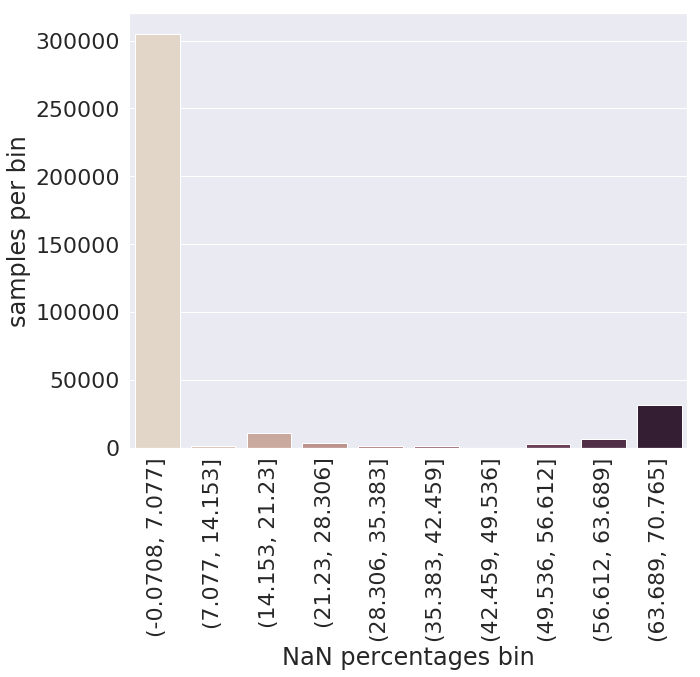

In [49]:
# the same in percent
var = results.value_counts()
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(10,8))
g = sns.barplot(x = var.index, y = var.values,
                  palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set(xlabel='NaN percentages bin', ylabel='samples per bin')

fig = g.get_figure()
#fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

# one sees a significant drop between 6th first columns and the rest
# a ratio of nan around 65% should do it

# Explora cleaned data - population

In [12]:
pop_df_selected = pd.read_pickle('pop_df_cleaned_with_nan.pkl')

In [17]:
pop_df_selected.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910220,NaN,9.0,NaN,21.0,11.0,0.0,0.0,2.0,0.0,3.0,...,3.0,1.0,0.0,0.0,4.0,3.0,9.0,4.0,5.0,1.0
910226,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,0.0,2.0,...,5.0,0.0,0.0,1.0,0.0,NaN,9.0,7.0,3.0,4.0
910244,3.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,0.0,2.0,...,3.0,0.0,0.0,0.0,2.0,6.0,9.0,7.0,4.0,1.0
910261,NaN,1.0,14.0,14.0,6.0,0.0,0.0,1.0,0.0,2.0,...,4.0,0.0,3.0,0.0,2.0,5.0,9.0,1.0,1.0,1.0
645153,NaN,5.0,17.0,17.0,9.0,0.0,0.0,1.0,0.0,2.0,...,5.0,0.0,23.0,0.0,4.0,4.0,3.0,7.0,4.0,3.0


## Let's see missing values

In [13]:
nan_counts = pop_df_selected.isnull().sum().sort_values(ascending=False)

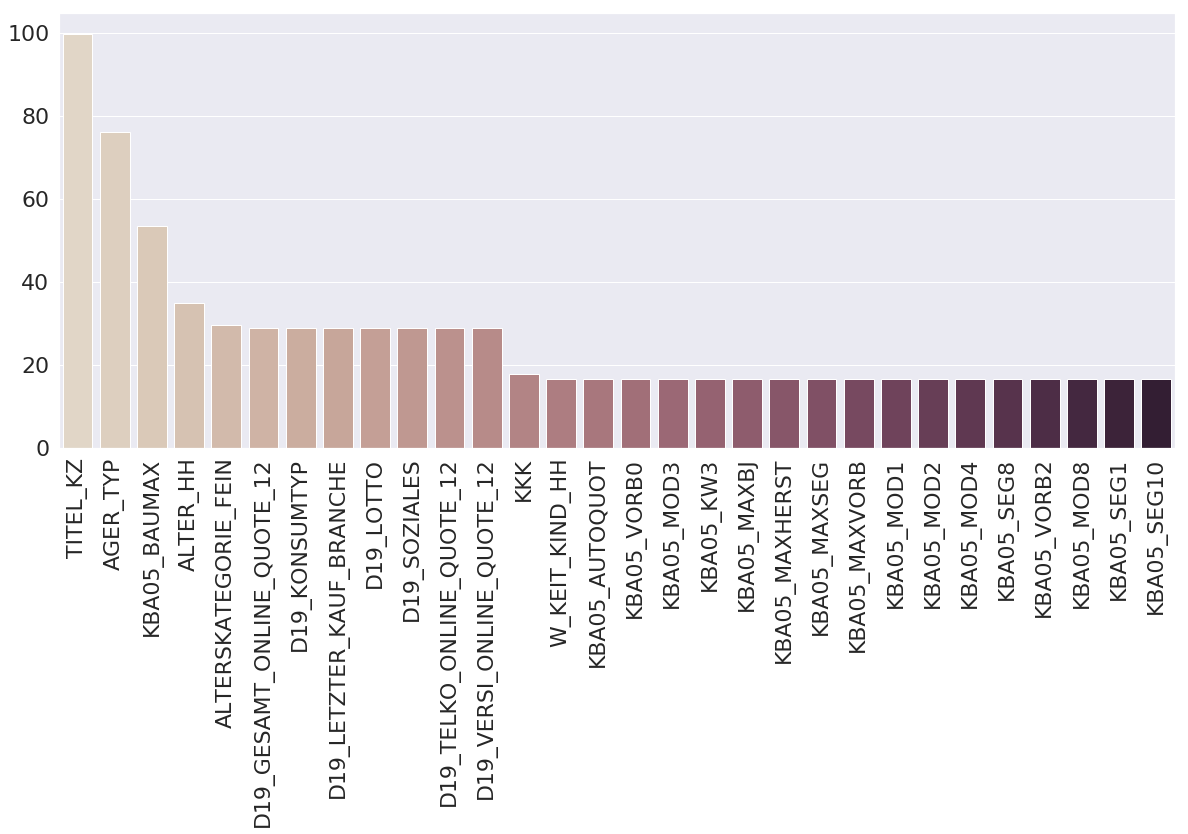

In [18]:
# the same in percent
top_ = 30
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(x = nan_counts.index[:top_], y = nan_counts.values[:top_]/pop_df_selected.shape[0]*100,
                  palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
fig = g.get_figure()
plt.show()
#fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

# one sees that TITEL_KZ contained almost only nan equivalent that were identified during cleaning steps
# also, AGER_TYP & KBA05_BAUMAX contained significant (>50%) amount of nan equivalent

In [26]:
df1

,class,survived,percent
0,First,1,62.962963
1,First,0,37.037037
2,Second,0,52.717391
3,Second,1,47.282609
4,Third,0,75.763747
5,Third,1,24.236253


In [22]:
pop_df_selected[col].value_counts(normalize=True).rename('percent')

-1    0.81
 2    0.09
 1    0.09
 3    0.01
Name: percent, dtype: float64

In [213]:
for col in pop_df_selected.columns:
    print(f'there are {pop_df_selected[col].nunique()} values in column {col}')

there are 5 values in column AGER_TYP
there are 9 values in column AKT_DAT_KL
there are 21 values in column ALTER_HH
there are 17 values in column ALTER_KIND1
there are 16 values in column ALTER_KIND2
there are 14 values in column ALTER_KIND3
there are 12 values in column ALTER_KIND4
there are 25 values in column ALTERSKATEGORIE_FEIN
there are 275 values in column ANZ_HAUSHALTE_AKTIV
there are 20 values in column ANZ_HH_TITEL
there are 9 values in column ANZ_KINDER
there are 24 values in column ANZ_PERSONEN
there are 252 values in column ANZ_STATISTISCHE_HAUSHALTE
there are 5 values in column ANZ_TITEL
there are 6 values in column ARBEIT
there are 7 values in column BALLRAUM
there are 45 values in column CAMEO_DEU_2015
there are 19 values in column CAMEO_DEUG_2015
there are 43 values in column CAMEO_INTL_2015
there are 6 values in column CJT_GESAMTTYP
there are 5 values in column CJT_KATALOGNUTZER
there are 5 values in column CJT_TYP_1
there are 5 values in column CJT_TYP_2
there are 5

there are 3 values in column KBA13_ANTG4
there are 1259 values in column KBA13_ANZAHL_PKW
there are 5 values in column KBA13_AUDI
there are 6 values in column KBA13_AUTOQUOTE
there are 5 values in column KBA13_BAUMAX
there are 5 values in column KBA13_BJ_1999
there are 5 values in column KBA13_BJ_2000
there are 5 values in column KBA13_BJ_2004
there are 5 values in column KBA13_BJ_2006
there are 6 values in column KBA13_BJ_2008
there are 6 values in column KBA13_BJ_2009
there are 5 values in column KBA13_BMW
there are 6 values in column KBA13_CCM_0_1400
there are 6 values in column KBA13_CCM_1000
there are 6 values in column KBA13_CCM_1200
there are 5 values in column KBA13_CCM_1400
there are 5 values in column KBA13_CCM_1401_2500
there are 5 values in column KBA13_CCM_1500
there are 5 values in column KBA13_CCM_1600
there are 6 values in column KBA13_CCM_1800
there are 5 values in column KBA13_CCM_2000
there are 6 values in column KBA13_CCM_2500
there are 6 values in column KBA13_CCM_

In [254]:
high_unique = []
for col in (set(pop_df_selected.columns) - set(col_numeric)):
    if pop_df_selected[col].nunique() > 10:
        high_unique.append(col)
        print(f'Column {col} is considered featuring a high number of unique values. {pop_df_selected[col].nunique()} unique values are identified')

Column VK_DHT4A is considered featuring a high number of unique values. 11 unique values are identified
Column VERDICHTUNGSRAUM is considered featuring a high number of unique values. 46 unique values are identified
Column EINGEFUEGT_AM is considered featuring a high number of unique values. 4274 unique values are identified
Column VK_DISTANZ is considered featuring a high number of unique values. 13 unique values are identified
Column ALTER_KIND4 is considered featuring a high number of unique values. 12 unique values are identified
Column LP_FAMILIE_FEIN is considered featuring a high number of unique values. 12 unique values are identified
Column PRAEGENDE_JUGENDJAHRE is considered featuring a high number of unique values. 16 unique values are identified
Column ANZ_STATISTISCHE_HAUSHALTE is considered featuring a high number of unique values. 252 unique values are identified
Column GFK_URLAUBERTYP is considered featuring a high number of unique values. 12 unique values are identifie

In [255]:
# let's see if we can discard low occurence
threshold = 0.02 # fraction
for col in pop_df_selected.columns:
    tot_values = pop_df_selected[col].shape[0]
    value_counts = pop_df_selected[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts/tot_values <= threshold].index
    pop_df_selected[col] = pop_df_selected[col].replace(to_remove, np.nan)

In [257]:
high_unique2 = []
for col in (set(pop_df_selected.columns) - set(col_numeric)):
    if pop_df_selected[col].nunique() > 10:
        high_unique2.append(col)
        print(f'Column {col} is considered featuring a high number of unique values. {pop_df_selected[col].nunique()} unique values are identified')

Column VK_DISTANZ is considered featuring a high number of unique values. 13 unique values are identified
Column PRAEGENDE_JUGENDJAHRE is considered featuring a high number of unique values. 13 unique values are identified
Column ANZ_STATISTISCHE_HAUSHALTE is considered featuring a high number of unique values. 11 unique values are identified
Column GFK_URLAUBERTYP is considered featuring a high number of unique values. 12 unique values are identified
Column CAMEO_INTL_2015 is considered featuring a high number of unique values. 14 unique values are identified
Column ALTER_HH is considered featuring a high number of unique values. 14 unique values are identified
Column ALTERSKATEGORIE_FEIN is considered featuring a high number of unique values. 13 unique values are identified
Column EINGEZOGENAM_HH_JAHR is considered featuring a high number of unique values. 22 unique values are identified
Column LP_LEBENSPHASE_FEIN is considered featuring a high number of unique values. 18 unique valu

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


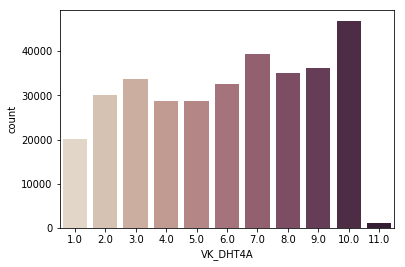

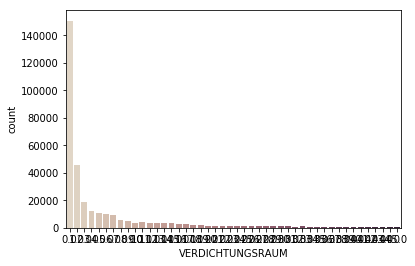

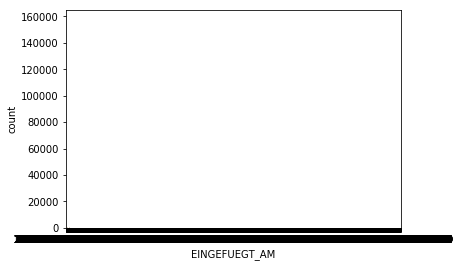

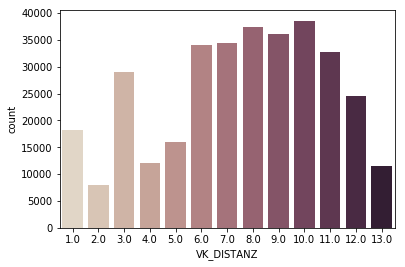

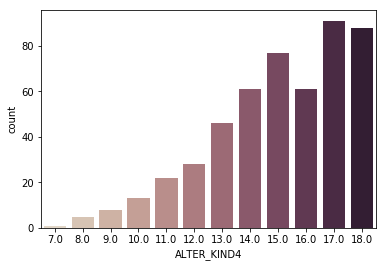

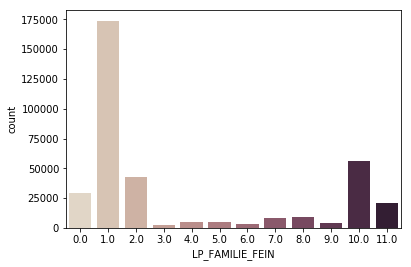

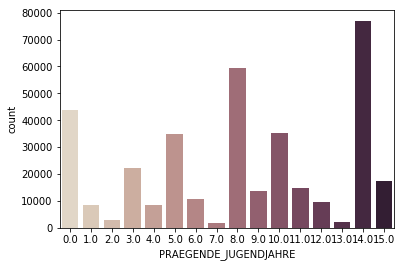

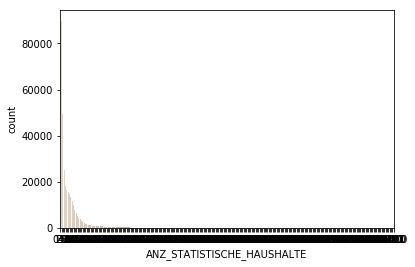

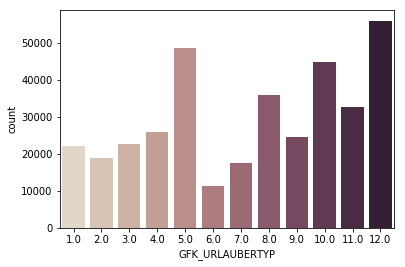

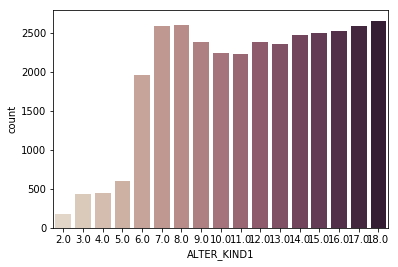

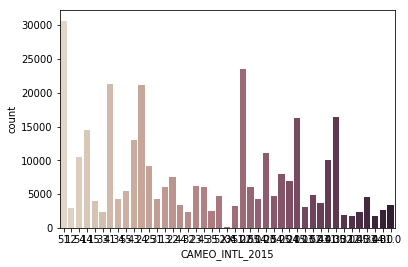

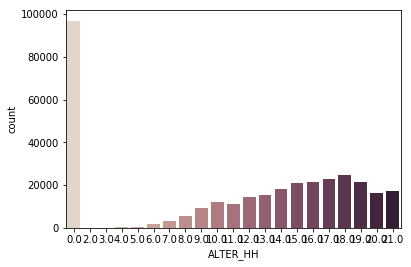

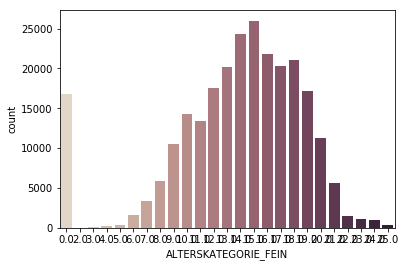

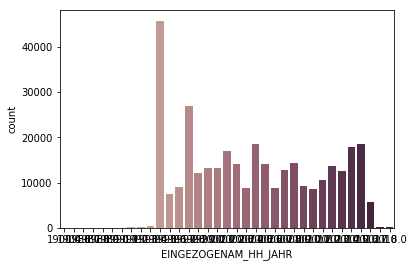

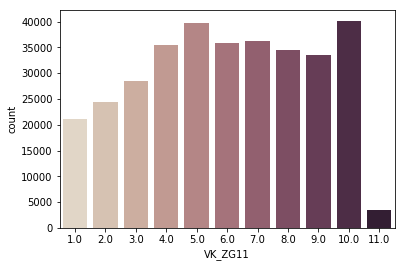

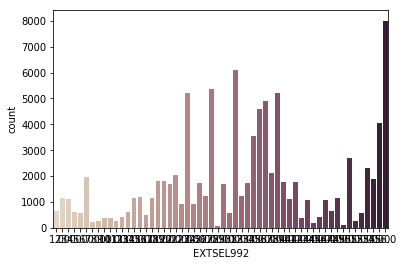

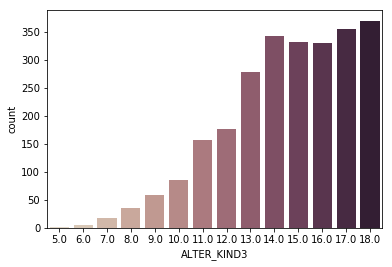

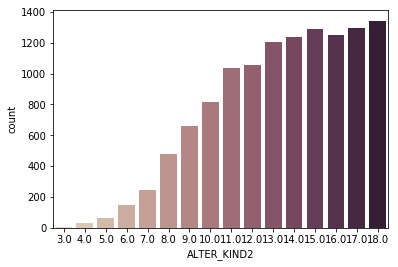

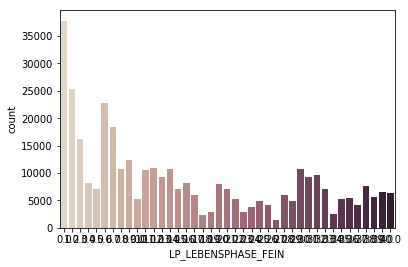

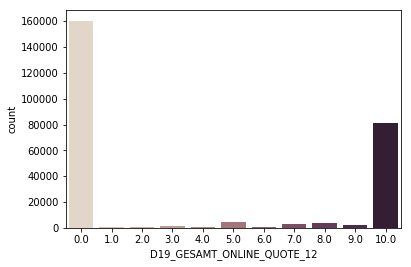

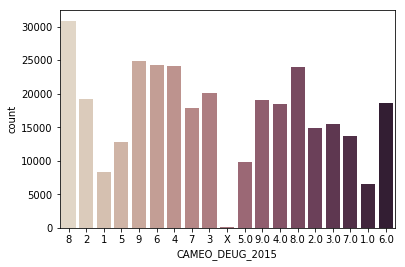

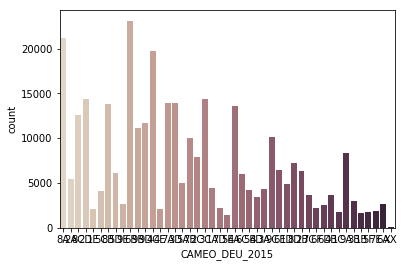

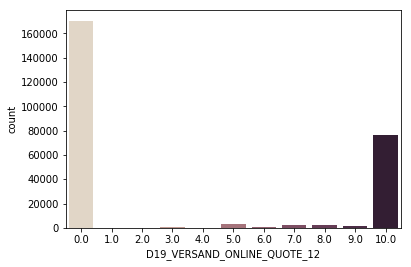

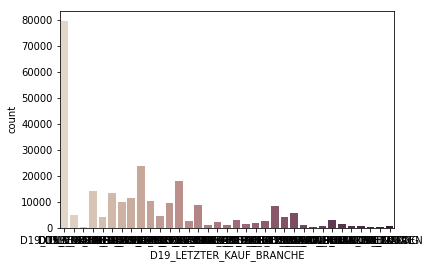

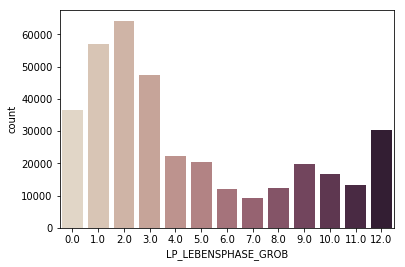

In [241]:
for col in high_unique:
    f, ax = plt.subplots()
    g = sns.countplot(x=col, 
                    data=pop_df_selected, 
                    palette="ch:.25")
    fig = g.get_figure()
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

# Other analysis

In [157]:
dataset.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,dataset,RESPONSE
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,population,NaN
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,population,NaN
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,population,NaN
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0,population,NaN
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,population,NaN


In [161]:
dataset.loc[dataset['dataset'].str.contains('population' or 'customers'), :].head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,dataset,RESPONSE
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,population,NaN
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,population,NaN
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,population,NaN
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0,population,NaN
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,population,NaN


In [176]:
LNR_cus = dataset.loc[dataset['dataset'].str.contains('customers'), :]['LNR'].values
LNR_pop = dataset.loc[dataset['dataset'].str.contains('population'), :]['LNR'].values

In [180]:
LNR_pop

array([910215, 910220, 910225, ..., 947738, 947740, 947746])

In [182]:
set(LNR_cus).intersection(LNR_pop)

set()